# The evolution of language in films

In [690]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf

from pyspark.sql import *
%matplotlib inline

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')

sqlContext = SQLContext(sc)
import sys
sys.getdefaultencoding()
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(16,10)})
sns.set_context({"font.size":15,"axes.titlesize":20,"axes.labelsize":18})
sns.set_style("darkgrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakobsvenningsson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Extraction of data

###  <font color='red'>NOTE:</font> All of the extraction of data has been done in the cluster. We have included the scripts in the notebook for the purpose of documentation.

Each subtitle in the OpenSubtitle database is stored in a seperate XML-file. In order to analyse the data and we need to convert it to a format more appropriate for Spark/Pandas. Instead of having ~180000 different XML-files, we would like to have the data stored in a dataframe.

In order to process the dataset using Spark, we will use the spark-xml package from databricks (https://github.com/databricks/spark-xml).

When using spark-xml, you can either let spark-xml infer the schema of the XML file or you can specify it yourself. Delegating the job of creating the schema to spark-xml is convenient however it is very expensive which we experienced through first hand experience. In order to speed up our input pipeline, we will specify or own static xml schema below. When specifying the schema yourself, spark-xml will not try to infer the schema which gives a significant performance boost when reading large numbers of XML-files.

## 0.1 schema

We will extract 2 seperate dataframes, therefore we will need two different XML schemas. One schema will be used to extract the movie meta data contained in each subtitle file and the other schema will be used to extract the actual subtitle text.

### 0.1.1 meta data schema

In [2]:
# Schema for the source XML-tag
sourceSchema = StructType([\
                            StructField('genre', StringType()),
                            StructField('year', StringType()),
                          ])

# Schema for the source XML-tag
subtitleSchema = StructType([\
                            StructField('duration', StringType())
                          ])

# Schema for the conversion XML-tag
conversionSchema =  StructType([\
                                StructField('sentences', StringType()),
                                StructField('tokens', StringType())
                              ])

# Schema for the meta XML-tag
mSchema = StructType([\
                        StructField('source', sourceSchema),
                        StructField('conversion', conversionSchema),
                        StructField('subtitle', subtitleSchema),
                    ])

# Root schema
metaSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('meta', mSchema)
])

### 0.1.1 subtitle data schema

The schema will produce a dataframe with two columns. One column will contain the movie id and a column **s** which is of type Array. The elements of the Array in column **s** holds elements which also are arrays. Each nested array represents a sentence and each element of the nested Arrays are the words of the sentence.

In [3]:
# Schema for the w (word) XML-tag
wordSchema = ArrayType(StructType([\
                                StructField('_VALUE', StringType())\
                               ]))

# Schema for the s (sentence) XML-tag
sentenceSchema = StructType([StructField('w', wordSchema)])

# Root schema
sentenceSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('s', ArrayType(sentenceSchema))
])

## 0.2 Parsing of xml-data

The OpenSubtitle dataset uses the following folder structure:

**opensubtitle/OpenSubtitles2018/xml/ { language } / { year } / { imdb_id } / { openSubtitle_id }.xml.gz**

* **year:** the release year of the movie
* **langauge:** the language of the movie
* **imdb_id:** id of the movie in the IMDB database
* **openSubtitle_id:** unique identifier in the opensubtitle database

With the help of regular expression we can load every single subtitle file at once using spark. 

### 0.2.1 meta data dataframe

**The meta data we extract for each movie is the following:**

* **_id**: the openSubtitle id - **type**: string
* **year**: the release year of the movie - **type**: numeric
* **sentences**: the total amount of sentences in the movie - **type**: numeric
* **words**: the total amount of words in the movie (not unique words) - **type**: numeric
* **duration**:: the duration of the movie - **type**: string
* **imdb_id**: id of the movie in the IMDB database - **type**: string

The imdb_id is actually not contained in the XML-file of each movie but the parent directory of each XML subtitle file is named using the imdb identifier. Therefore, we extract the imdb_id from the file path of each subtitle file.

In [7]:
# Loads all subtitles files in english and parses the input files with the schema for meta data.
metadata_df = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=metaSchema)

In [60]:
metadata_df = metadata_df.select(\
               F.col("_id"),\
               F.col("meta.source.genre").alias("genre"),\
               F.col("meta.source.year").alias("year"),\
               F.col("meta.conversion.sentences").alias("sentences"),\
               F.col("meta.conversion.tokens").alias("words"),\
               F.col("meta.subtitle.duration").alias("duration"))  

metadata_df = metadata_df.withColumn("imdb_id",F.split(F.input_file_name(), "/").getItem(6))

In [ ]:
# number of words, sentences, numVotes and year are ints 
metadata_df = metadata_df.withColumn("words", movies["words"].cast("int"))
metadata_df = metadata_df.withColumn("sentences", movies["sentences"].cast("int"))
metadata_df = metadata_df.withColumn("year", movies["year"].cast("int"))

# convert duration to minutes
@F.udf('string')
def convert_duration(duration):
    try:
        return str(int(duration[:2]) * 60 + int(duration[3:5]))
    except:
        return "0"
    
metadata_df = metadata_df.withColumn("duration", convert_duration(metadata_df.duration))

In [ ]:
metadata_df.write.mode("overwrite").parquet('./datasets/metadata_final.parquet')

### 0.2.1 subtitle dataframe

The subtitle dataframe has the following structure:

* **_id:** the openSubtitle id - **type**: string
* **sentence:** a sentence belonging to the movie identified by the **_id** field - **type**: List of List(String)

In [ ]:
# Loads all subtitles files in english and parses the input files with the schema for subtitle data.
df_subtitle = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=sentenceSchema)

In [ ]:
# The tag s.w in the nested XML-structure holds an array of sentences for each movie.
# We want each movie to have its own entry in the dataframe, we use the explode function to create one row
# in the dataframe for each nested array contained in the s.w tag
df_subtitle = df.select('_id',
                            F.explode(F.col('s.w')).alias('sentence'))

In [ ]:
@F.udf('string')
def flatMapSentence(sentence):
    if sentence == None:
        return []
    return [item for sublist in sentence for item in sublist]

df_subtitle = df_subtitle.withColumn('sentence', flatMapSentence(F.col('sentence')))

In [ ]:
df_subtitle.write.mode("overwrite").parquet('./datasets/subtitles_final.parquet')

## 0.3 Enriching the dataset

With the help of the imdb_id, we can enrich our dataset with one or several of IMDBs public datasets (https://www.imdb.com/interfaces/). We are interested in the imdb rating of each movie, let's add it to our existing movies dataframe by joining it with the ratings dataset of IMDB.

In [18]:
metadata_df = spark.read.parquet("./datasets/metadata_df.parquet")
metadata_df = metadata_df.withColumn('numVotes', F.col('numVotes').cast('int'))
metadata_df = metadata_df.withColumn('averageRating', F.col('averageRating').cast('float'))
movies_imdb.show(3)

+-------+--------------------+----+---------+-----+------------+-------+
|    _id|               genre|year|sentences|words|    duration|imdb_id|
+-------+--------------------+----+---------+-----+------------+-------+
|7018237|Comedy,Drama,Romance|1947|     2768|20350|01:55:25,969|  39477|
|3528271| Crime,Drama,Fantasy|1993|     1557|10885|01:56:41,202| 107665|
|4655639|Animation,Comedy,...|1935|      142|  457|00:15:15,010|  26706|
+-------+--------------------+----+---------+-----+------------+-------+
only showing top 3 rows



In [19]:
imdb_ratings = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("sep", "\t").load("title.ratings.tsv")
imdb_ratings.show(3)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1437|
|tt0000002|          6.3|     171|
|tt0000003|          6.6|    1037|
+---------+-------------+--------+
only showing top 3 rows



The imdb ids in the IMDB dataset has a few minor differences compared to the imdb ids in the OpenSubtitle dataset. 

1. The id's in the IMDB dataset are prefixed with the string "tt"
2. The id's in the OpenSubtitle dataset has stripped away leading zeros in the imdb id

Let's define a simple spark UDF which will take care of both inconsistencies:

In [20]:
remove_prefix_and_leading_zeros = F.udf(lambda x: x[2:].lstrip('0'), StringType())

In [21]:
remove_prefix = F.udf(lambda x: x[2:], StringType())
imdb_ratings = imdb_ratings.select('averageRating', 
                                   'numVotes', 
                                   remove_prefix_and_leading_zeros(F.col('tconst')).alias('id'))
# we do a left outer join since we still want to keep movies from our original dataset that 
# does not match any movies in the imdb dataset.
metadata_df = metadata_df.join(imdb_ratings, metadata_df.imdb_id == imdb_ratings.id, "left_outer")\
     .select('_id', 'genre', 'year', 'sentences', 'words', 'duration', 'numVotes', 'averageRating', 'imdb_id')
metadata_df.show(3)

+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
|    _id|               genre|year|sentences|words|    duration|numVotes|averageRating|imdb_id|
+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
|4579146|Comedy,Drama,Romance|1990|     1332| 9373|01:39:48,845|   25410|          6.6| 100140|
|3678600|Comedy,Drama,Romance|1990|     1344| 9365|01:41:20,585|   25410|          6.6| 100140|
|6325233|Comedy,Drama,Romance|1990|     2066|15353|01:50:03,583|   25410|          6.6| 100140|
+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
only showing top 3 rows



In [22]:
metadata_df.write.mode("overwrite").parquet('./datasets/metadata_df.parquet')

# 1. Descriptive statistics

## 1.1 Meta data dataframe

Before working with our data, let's get to know it. We will start by getting the movie data.

In [655]:
movies = spark.read.parquet("./datasets/metadata_final.parquet") #177039
print("There are " + str(movies.count()) + " entries in the dataset.")

There are 74674 entries in the dataset.


What information do we have for every movie?

In [656]:
movies.schema

StructType(List(StructField(_id,IntegerType,true),StructField(genre,StringType,true),StructField(year,IntegerType,true),StructField(sentences,IntegerType,true),StructField(words,IntegerType,true),StructField(duration,IntegerType,true),StructField(numVotes,IntegerType,true),StructField(averageRating,FloatType,true),StructField(imdb_id,StringType,true)))

In [657]:
# convert to DF format
movies = movies.toDF('id', 
                     'genre', 
                     'year', 
                     'sentences', 
                     'words', 
                     'duration', 
                     'numVotes', 
                     'averageRating', 
                     'imdb_id')

movies.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sentences: integer (nullable = true)
 |-- words: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- imdb_id: string (nullable = true)



Our dataset contains a lot of TV series along with the movies. We can say that almost all TV series are less than 60 minutes long, while almost all movies are longer than 60 minutes.

Considering we want __only__ films in our dataset, we will remove all entries which have a duration of less than 60 minutes. This should remove the great majority of TV series and keep the great majority of films in our dataset.

In [658]:
movies = movies.filter(movies.duration > 60) 
print("We are left with " + str(movies.count()) + " films after removing the TV series.")

We are left with 74674 films after removing the TV series.


### 1.1.1 Number of movies by year

So how many movies are there for each year? We presume there will be more movies in recent years than 1950. 

Firstly, we check the range of the years.

In [659]:
movies.describe('year').show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|             74416|
|   mean|1995.3661175016125|
| stddev| 21.92565919323367|
|    min|              1896|
|    max|              2017|
+-------+------------------+



Now let's draw a chart showing exactly how many movies were there for each year.

In [660]:
# get movie counts per year
movies_per_year = movies.groupby('year').count()

# convert to Pandas for plotting
ydf = movies_per_year.toPandas()

# sort the films by year
ydf = ydf.sort_values(by='year')

We need to clean our data of null values and inconsistent entries.

In [661]:
n_before = sum(ydf['count'])
print("Before cleaning we have " + str(n_before) + " films. ")

# convert year to int the 'year' value
ydf['year'] = pd.to_numeric(ydf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ydf = ydf.dropna()
ydf = ydf.reset_index(drop=True)
ydf['year'] = ydf['year'].astype('int')

n_after = sum(ydf['count'])
print("After cleaning we have " + str(n_after) + " films. ")
print("Only %.5f%% of our dataset was invalid/inconsistent." % (1 - (n_after/n_before)))

Before cleaning we have 74674 films. 
After cleaning we have 74416 films. 
Only 0.00346% of our dataset was invalid/inconsistent.


To plot the number of films by year, we will bin them to make the visualization clearer.

Considering we have movies from 1896 to 2020, we are going to make 13 bins for each decade from 1890s to 2010s (We are going to put year 2020 in 2010s, it will not change much because we have only  6 films for 2020)

In [662]:
years = list(ydf['year'])
labels = []
counts = []

for decade in range(1890, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            count += int(ydf.loc[ydf['year'] == year]['count'])
    counts.append(count)

# add the 2020 to the 2010s decade
counts[11] += int(ydf.loc[ydf['year'] == 2010]['count'])

Text(0.5,1,'Number of movies per decade')

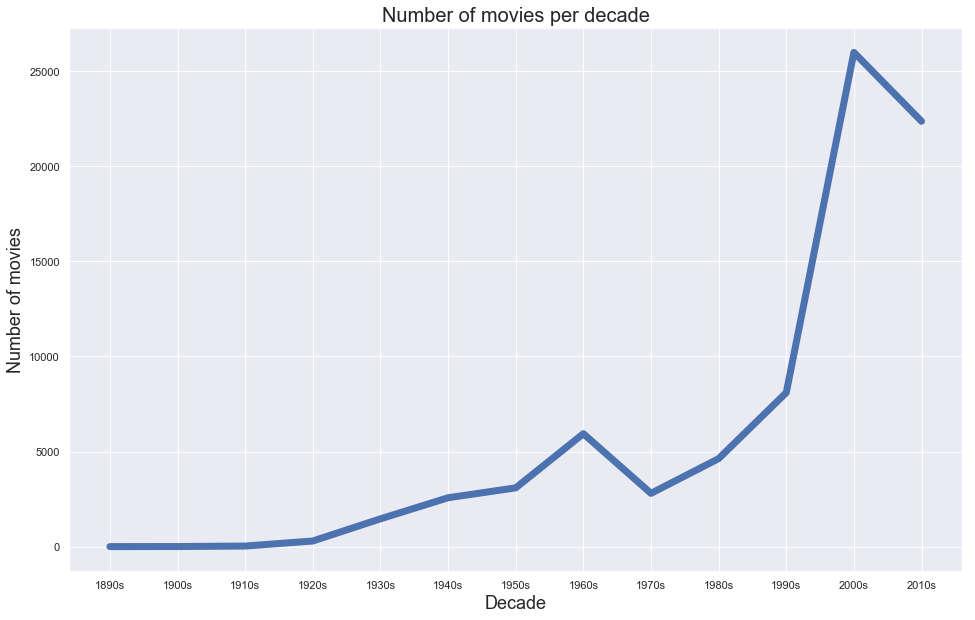

In [663]:
data_movie_dist = pd.DataFrame({'Decade': labels, 'Number of movies':counts})
sns.lineplot(x='Decade',
             y='Number of movies', 
             linewidth=7.0,
             data=data_movie_dist).set_title('Number of movies per decade')

As expected, we have more films in the recent decades. We can see from the plot above that the amount of data from the 1900s and 1910s decades are very low. Let's have a look at the exact number:

In [664]:
regex1900 = "190[0-9]"
regex1890 = "189[0-9]"
print("Number of movies from 1890s: {}".format(movies.filter(movies["year"].rlike(regex1890)).count()))
print("Number of movies from 1900s: {}".format(movies.filter(movies["year"].rlike(regex1900)).count()))

Number of movies from 1890s: 1
Number of movies from 1900s: 4


No meaningful analysis about the 1890s and 1900s can be done with so few data points, we will therefore drop these entries from the data set.

In [665]:
movies = movies.filter((movies["year"].rlike(regex1890) == False))
movies = movies.filter((movies["year"].rlike(regex1900) == False))

### 1.1.2 Median number of sentences by year

Our project is about evolution of language used in films, so let's have a peek at how and did it change over time. We will start by showing the median number of sentences for each year. We use median instead of mean since it's a more robust measure so in the case we have some invalid data (like unfinished movie subtitles with just a few sentences) it will behave better.

In [666]:
@F.udf('string')
def toDecade(year):
    decade = year - (year % 10)
    return str(decade) + "s"
movies = movies.withColumn('decade', toDecade('year'))

# get median number of sentences per decade
percentile = F.expr('percentile_approx(sentences, 0.5)')
sdf_ = movies.groupby('decade').agg(percentile.alias('n_sent_median'))
# convert to Pandas for plotting
sdf = sdf_.toPandas()

We will now visualize the median number of sentences by decade. For each decade, we will take the average of medians for that decade. We will ignore year 2020 (for all decades to have exactly 10 years).

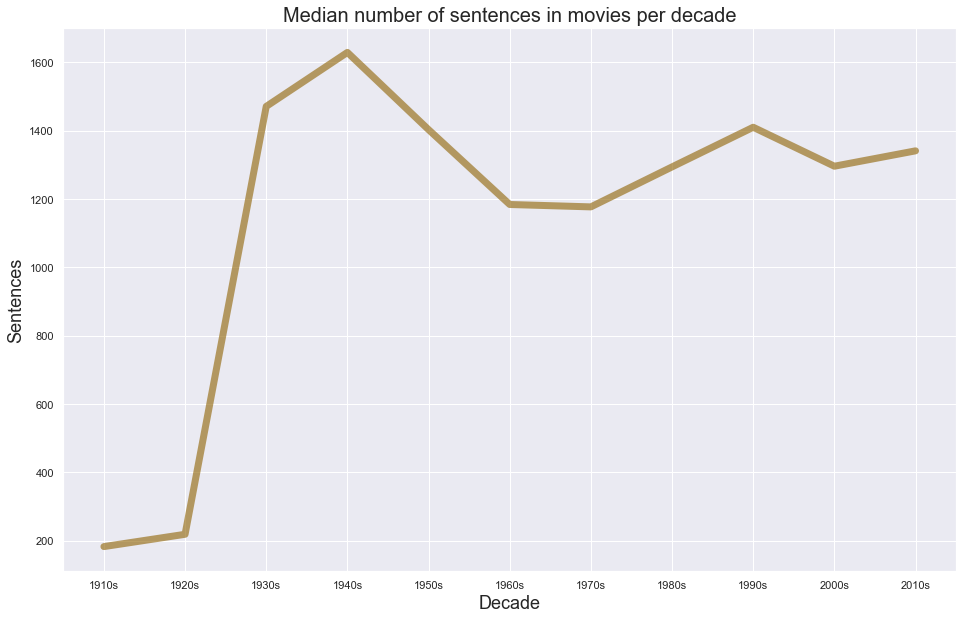

In [667]:
median_sentence_data = pd.DataFrame({'Decade': sdf['decade'], 'Sentences':sdf['n_sent_median']})
ax = sns.lineplot(x='Decade',
             y='Sentences', 
             linewidth=7.0,
             color='#946a0fa4',
             data=median_sentence_data).set_title('Median number of sentences in movies per decade')

#plt.figure(figsize=(15,10))
#plt.bar(labels, medians)
#plt.title('Median number of sentences per decade')
#plt.show()

On this graph we can see some interesting things. Before 1930s, in the era of the silent films, there is a low number of sentences for each movie. In the 30s, the first decade of the "sound era", the number gets much larger: the movies have proper dialogue now. In the later decades, it seems the number has lowered a bit, but it didn't change much and is mostly around 1000 to 1400 senences per film.

### 1.1.3 Median number of words in sentences by year

We already checked sentences, but they can hide something. The number of words is also important. A movie can have many sentences but most of them can be very short. So let's check the median number of words per year and visualize it.

In [668]:
# get median number of words per year
percentile = F.expr('percentile_approx(words, 0.5)')
wdf_ = movies.groupby('year').agg(percentile.alias('n_word_median'))

# convert to Pandas for plotting
wdf = wdf_.toPandas()

# sort the films by year
wdf = wdf.sort_values(by='year')

# convert year to int the 'year' value
wdf['year'] = pd.to_numeric(wdf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
wdf = wdf.dropna()
wdf = wdf.reset_index(drop=True)
wdf['year'] = wdf['year'].astype('int')

In [669]:
years = list(wdf['year'])
labels = []
medians = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(wdf.loc[wdf['year'] == year]['n_word_median'])
            count += 1
    medians.append(median / count)

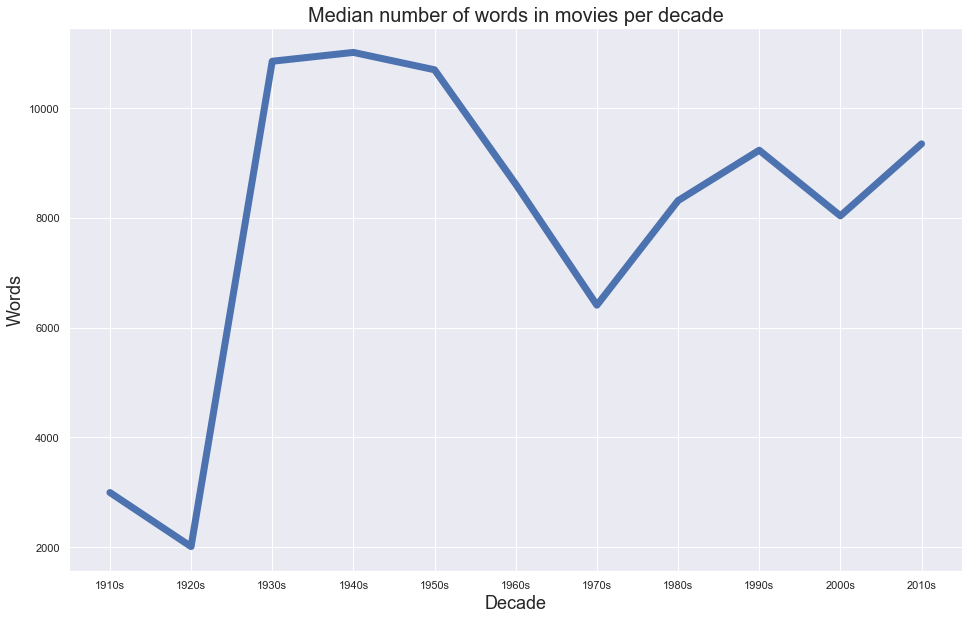

In [670]:
data = pd.DataFrame({'Decade': labels, 'Words':medians})
ax = sns.lineplot(x='Decade',
             y='Words', 
             linewidth=7.0,
             data=data).set_title('Median number of words in movies per decade')
#plt.figure(figsize=(15,10))
#plt.bar(labels, medians)
#plt.title('Median number of words per decade')
#plt.show()

The graph seems very similar to the sentences graph in the previous section. So we can assume that number of words for each sentence did not really change.

### 1.1.4 Median film duration by year

Looking at the number of sentences per year we noticed that there is a smaller number of sentences in films in recent decades. However, could it be just because films were longer in the past? 

We will check the median film duration for every year. Again, we will visualize it in decades, taking the average of the median for each year of the decade. 

In [671]:
# get median duration per year
percentile = F.expr('percentile_approx(duration, 0.5)')
ddf_ = movies.groupby('year').agg(percentile.alias('duration_median'))

# convert to Pandas for plotting
ddf = ddf_.toPandas()

# sort the films by year
ddf = ddf.sort_values(by='year')

# convert year to int the 'year' value
ddf['year'] = pd.to_numeric(ddf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ddf = ddf.dropna()
ddf = ddf.reset_index(drop=True)
ddf['year'] = ddf['year'].astype('int')

In [672]:
years = list(ddf['year'])
labels = []
medians = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(ddf.loc[wdf['year'] == year]['duration_median'])
            count += 1
    medians.append(median / count)

(0, 110)

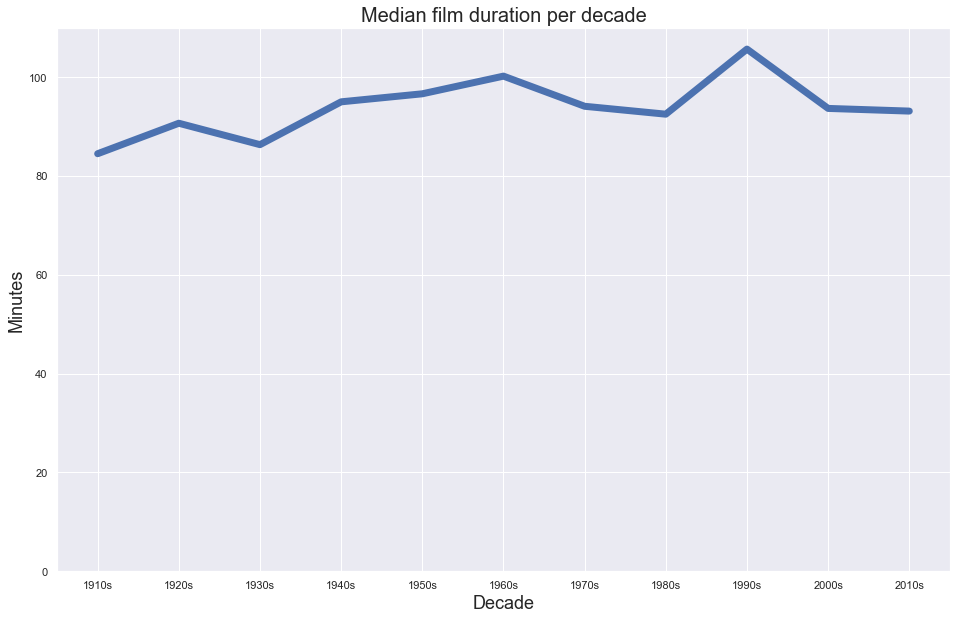

In [673]:
film_duration_data = pd.DataFrame({'Decade': labels, 'Minutes':medians})
ax = sns.lineplot(x='Decade',
             y='Minutes', 
             linewidth=7.0,
             data=film_duration_data).set_title('Median film duration per decade')
plt.ylim(0, 110)
#plt.figure(figsize=(15,10))
#plt.bar(labels, medians)
#plt.title('Median duration per decade (in minutes)')
#plt.show()

As can be seen, the duration of the films did not really change by the years. The median duration is always around 85 to 105 minutes, even in the silent film era.

### 1.1.5 Distribution of genres

We are going to see what is the distribution of genres in our dataset.

In [674]:
# make genre column into a list of genres
movies_ = movies.withColumn("genre", F.split(movies.genre, ','))

# make a row for each genre
movies_ = movies_.withColumn("genre", F.explode("genre"))

# get count of each genre
genres_ = movies_.groupby('genre').count()

# convert to Pandas for plotting
genres = genres_.toPandas()

print("We have " + str(len(genres)) + " genres.")

We have 42 genres.


For visualization, we are going to remove the genres with a low count (which have less than 1000 entries).

Also, we are going to sort them by count.

In [675]:
genres = genres.query("count > 1000")
genres = genres.sort_values(by='count')

Let's plot the distribution of genres as a pie chart.

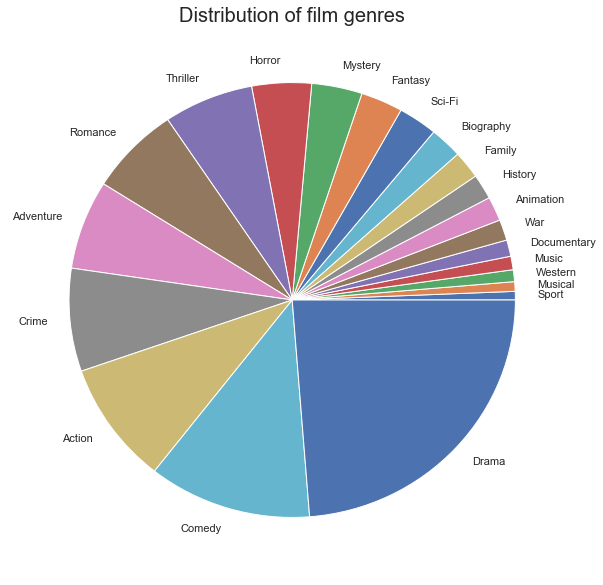

In [676]:
plt.figure(figsize=(10,10))
plt.pie(genres['count'], labels=genres['genre'])
plt.title('Distribution of film genres')
plt.show()

### 1.1.5 Distribution of IMDB ratings

Let's start by filtering out all movies which we don't have an IMDB rating 

In [677]:
movies_with_rating = movies.filter(F.col("averageRating").isNotNull())

How large porportion of the movies in our dataset contains IMDB ratings?

In [678]:
number_of_movies_with_ratings = movies_with_rating.count()
number_of_movies = movies.count()
print(round(number_of_movies_with_ratings / number_of_movies, 3))

0.994


We have ratings for close to all of the movies in our dataset, great!

Let's have a look at the distribution of imdb ratings:

In [679]:
movies_with_ratings_pandas = movies_with_rating.toPandas()
movies_with_ratings_pandas['numVotes'] = movies_with_ratings_pandas['numVotes'].astype(int)
movies_with_ratings_pandas['averageRating'] = movies_with_ratings_pandas['averageRating'].astype(float)

Text(0.5,0,'IMDB rating')

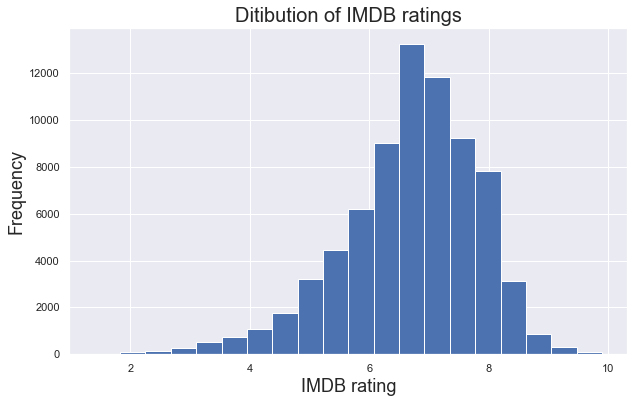

In [680]:
ax = movies_with_ratings_pandas['averageRating']\
    .plot\
    .hist(title="Ditibution of IMDB ratings", grid=True, figsize=(10,6), bins=20)
ax.set_xlabel("IMDB rating")

Judging from the above plot, it appears that the imdb ratings follow a normal distribution with a slight tail to the left and a mean of around ~7.

### 1.1.5 Mean film rating by decade

Let's first start with dropping rows which contain null values in the year column.

In [681]:
movies_with_ratings_pandas = movies_with_ratings_pandas.dropna(subset=['year'])

We bin our movies into decades by rounding the year column to the closest decade.

In [682]:
movies_with_ratings_pandas['decade'] = (movies_with_ratings_pandas['year'] - (movies_with_ratings_pandas['year'] % 10)).astype(int)

In order to get the mean of each decade, we group by the decade column and aggregate by taking the mean.

In [683]:
decade_imdb_mean = movies_with_ratings_pandas\
    .groupby('decade')\
    .mean()['averageRating']
decade_imdb_mean.index = decade_imdb_mean.index.astype(str) + "s"

(3, 8)

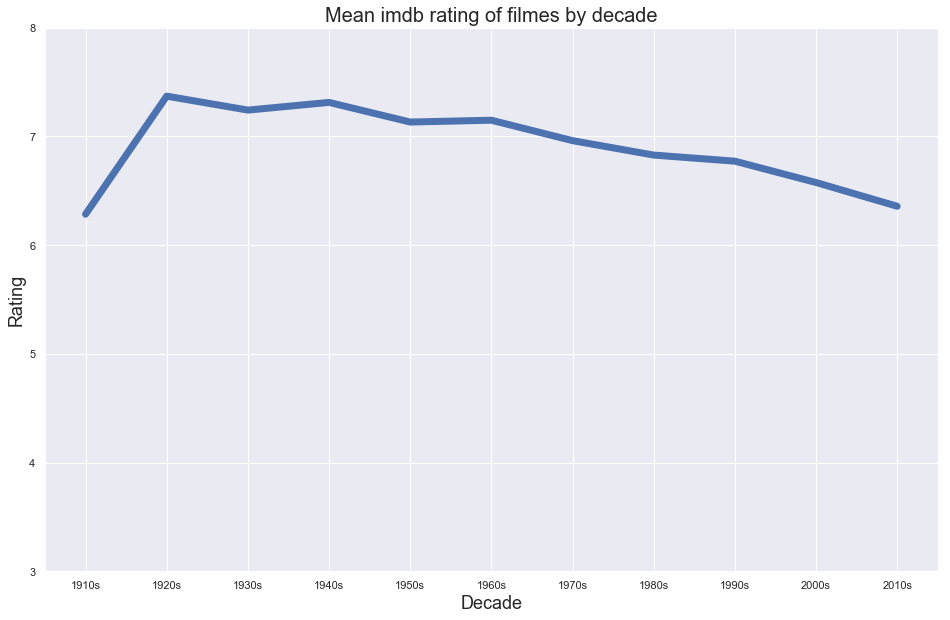

In [684]:
data = pd.DataFrame({'Decade': decade_imdb_mean.index, 'Rating':decade_imdb_mean})
ax = sns.lineplot(x='Decade',
             y='Rating', 
             linewidth=7.0,
             data=data).set_title('Mean imdb rating of filmes by decade')
plt.ylim(3, 8)
#plt.figure(figsize=(15,10))
#ax = plt.bar(decade_imdb_mean.index, decade_imdb_mean)
#plt.title('Mean imdb rating per decade')
#plt.xlabel('Decade')
#plt.ylabel('Mean IMDB rating')
#plt.show()

There are two key observations in the above plot:

1. The mean imdb rating has a peak around 1920-1940s.
2. The mean imdb rating has slowly but consistently decreased after the 1960s until today

## 1.2 Subtitle dataframe
Let's start by importing the dataframe and printing its schema.

In [685]:
subtitle_df = spark.read.parquet("./datasets/subtitles_final.parquet")

In [686]:
subtitle_df.printSchema()
subtitle_df.show()

root
 |-- _id: integer (nullable = true)
 |-- sentence: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|[They, 're, indep...|
|5131043|[they, 're, affec...|
|5131043|[they, 're, loyal...|
|5131043|[they, 're, sagac...|
|5131043|[they, 're, ineff...|
|5131043|[Cats, are, magic...|
|5131043|[They, really, ar...|
|5131043|[Probably, the, m...|
|5131043|[They, 're, also,...|
|5131043|[they, 're, very,...|
|5131043|[That, 's, anothe...|
|5131043|[The, domestic, c...|
|5131043|[Within, even, th...|
|5131043|[Even, after, tho...|
|5131043|[Now, ,, scientis...|
|5131043|[For, them, ,, th...|
|5131043|[To, share, one, ...|
|5131043|[Perhaps, the, wr...|
|5131043|[", God, made, th...|
|5131043|[Today, ,, the, W...|
+-------+--------------------+
only showing top 20 rows



Let's count the total amount of sentences we have in our dataframe:

In [177]:
print("Total amount of sentences: {}".format(subtitle_df.count())) 

Total amount of sentences: 104322445


Let's continue by counting the total amount of words. Since each sentence is saved as an array of words, we can easily calculate the sentence length by computing the length of each sentence array and if we later sum over this column we will get the total amount of words in the dataframe.

In [178]:
# Create column with sentence length
subtitle_df = subtitle_df.withColumn('sentence_length',F.size(F.col('sentence')))

# Sum all sentence lenegths to get total amount of words
total_amount_of_words = subtitle_df.groupBy().sum().collect()

In [179]:
print("Total amount of words: {}".format(total_amount_of_words[0][1])) 

Total amount of words: 746037179


As can be observed in the above printouts, we are dealing with a lot of text. However, it's important to note that not all words will be used in the analysis. We will elaborate more on this below in the **Preprocessing** section.

# 2. Preprocessing (SHOULD BE REWRITTEN/REMOVED)

Before starting the text analysis, we will do some preprocessing steps in order to transform the subtitle texts to a more suitable format and remove undesirable parts. 

As previously mentioned in the parsing section, sentences are stored as lists of strings. For instance the sentence "You're a lovely person." would be represented by the following list:
`["You", "'re", "a", "lovely", "person", "."]`.


There are a few types of words that we do not desire to be part of the analysis, we want to remove common words that do not add any value or meaning to the text. One such category is stop words (https://en.wikipedia.org/wiki/Stop_words). 

We also do not care about the punctuations (https://en.wikipedia.org/wiki/Punctuation) hence we will remove those as well.  

Finally, we also want to transform each word into its "base" form. For instance, the words take, took and taken should be treated as a single word in the analysis and not as three different ones. We will use Lemmatisation (https://en.wikipedia.org/wiki/Lemmatisation) in order to turn "took" and "taken" into their verb base form which is "take". However, we do not only want to lemmatize words but also other cases such as transforming plural words into singular and remove the -ing part of words (walking -> walk) etc.

Note from the above example sentence that contracted words (https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) are represented as two words in the sentence list. This makes sence when calculating the length of each sentence since a contracted word is actually two words. However, the part on the right hande side of the apostrophe in the contracted word does not add any value to our analysis. Therefore we will drop any word which starts with an apostrophe. 

Finally, we also want to transform each word into lower case. We want the words "Take" and "take" to be treated as the same word.

To summerize, we are doing the folloing preprocessing steps of our subtitle data:

1. Transform each word into lower case 
2. Remove stop words
3. Remove punctuation 
4. Lemmatize words
5. Remove words which starts with an apostrophe

Let's perform the 5 steps described above!

In [17]:
subtitle_df = spark.read.parquet("./movie_subtitle_final.parquet")
# Filter empty sentences
subtitle_df = subtitle_df.filter(F.size(F.col('sentence._VALUE')) > 0)
subtitle_df.show(3)

+-------+--------------------+---------------+
|    _id|            sentence|sentence_length|
+-------+--------------------+---------------+
|5131043|[[They], ['re], [...|              4|
|5131043|[[they], ['re], [...|              4|
|5131043|[[they], ['re], [...|              8|
+-------+--------------------+---------------+
only showing top 3 rows



**(1)** Let's convert each word into its lower case representation:

In [18]:
toLowerSentence = F.udf(lambda x: list(map(lambda y: y.lower() if y != None else y, x)), ArrayType(StringType()))
subtitle_df = subtitle_df.select('_id', 
                                 toLowerSentence('sentence._VALUE').alias('sentence'), 
                                 F.col('sentence_length').alias('original_sentence_length'))
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|[they, 're, indep...|                       4|
|5131043|[they, 're, affec...|                       4|
|5131043|[they, 're, loyal...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(2)** We will take help from the NLTK library(https://www.nltk.org/) to filter out stop words. NLTK provides predefined lists of stop words for several different languages, we will use the list for the english language. 

In [10]:
stop_words=set(stopwords.words('english'))
wordInStopWords = F.udf(lambda x: list(filter(lambda y: y not in stop_words,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', wordInStopWords('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|['re, independent...|                       4|
|5131043|['re, affectionat...|                       4|
|5131043|['re, loyal, ;, '...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(3)** To filter out punctuations, we can use the built in puncuation list contained in the string class of Python.

In [11]:
punctuation_list=list(string.punctuation)
remvovePunctuation = F.udf(lambda x: list(filter(lambda y: y not in punctuation_list,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', remvovePunctuation('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|  ['re, independent]|                       4|
|5131043| ['re, affectionate]|                       4|
|5131043|['re, loyal, 're,...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(4)** The NLTK library provies a lemmatizer API.

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmatize = F.udf(lambda x: lemmatizer.lemmatize(x, 'v'), StringType())
subtitle_df = subtitle_df.select('_id', lemmatize(F.col('word')).alias('word'), 'original_sentence_length')

**(5)** Remove words starting with an apostrophe

In [12]:
removeApostopheWords = F.udf(lambda x: list(filter(lambda y: y[0] != "'",x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', removeApostopheWords('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+------------------+------------------------+
|    _id|          sentence|original_sentence_length|
+-------+------------------+------------------------+
|5131043|     [independent]|                       4|
|5131043|    [affectionate]|                       4|
|5131043|[loyal, beautiful]|                       8|
+-------+------------------+------------------------+
only showing top 3 rows



Let's have a look on the poportion of words that has been filtered out during the above steps:

In [13]:
subtitle_df = subtitle_df.withColumn('sentence_length_after_filtering',F.size(F.col('sentence')))
total_amount_of_words = subtitle_df.groupBy().sum().collect()
total_amount_of_words

[Row(sum(_id)=15380688203805207, sum(original_sentence_length)=1276487464, sum(sentence_length_after_filtering)=468131830)]

In [14]:
print("Total amount of words before filtering: {}".format(total_amount_of_words[0][1]))
print("Total amount of words after filtering: {}".format(total_amount_of_words[0][2]))
print("Percentage of original size: {}".format(round(total_amount_of_words[0][2]/total_amount_of_words[0][1], 3)))

Total amount of words before filtering: 1276487464
Total amount of words after filtering: 468131830
Percentage of original size: 0.367


After removing punctuations and stop words we are only left with roughly a third of the words of the original dataset. 

# 3. Analysis

This section contains an analysis of the text readability/complexity of movies, a sentiment analysis and an analysis of the frequency of profanities in movies. 

## 3.1 Text complexity analysis

### 3.1.1 Quantification of text complexity

In this subsection we will analyse the textual complexity/readability of each movie in our dataset. To meassure the complexity, we will use the Dale-Challe readability forumla (https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula). 

The Dale–Challe readability formula is given by the equation below:

$$Complexity = 0.1579 * (\frac{\text{difficult words}}{\text{words}} * 100) + 0.0496 * (\frac{\text{words}}{\text{sentences}})$$

In addition to the equation above, If the fraction of difficult words account for more than 5% of the total words then the complexity score is scaled by a constant of 3.6365.

The score is interpreted gives information about the eduction level neccesary to understand the text. The scoring table is the following:


* 4.9 or lower	easily understood by an average 4th-grade student or lower
* 5.0–5.9	easily understood by an average 5th or 6th-grade student
* 6.0–6.9	easily understood by an average 7th or 8th-grade student
* 7.0–7.9	easily understood by an average 9th or 10th-grade student
* 8.0–8.9	easily understood by an average 11th or 12th-grade student
* 9.0–9.9	easily understood by an average 13th to 15th-grade (college) student

Source: Wikipedia

### 3.1.2 Calculation of complexity for each movie

Let's start by importing our subtitle data frame.

In [61]:
subtitle_df = spark.read.parquet('./datasets/subtitles_final.parquet')
subtitle_df.show(3)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|[They, 're, indep...|
|5131043|[they, 're, affec...|
|5131043|[they, 're, loyal...|
+-------+--------------------+
only showing top 3 rows



The words which belong to the "difficult word" class is all the words which are not present in a list of rougly 3000 "easy" words. Let's import the "easy word" list.

In [62]:
easy_words = sqlContext.read.text('DaleChallEasyWordList.txt').collect()
easy_words = list(map(lambda x: x.value.strip(), easy_words))
easy_words[:10]

['a',
 'able',
 'aboard',
 'about',
 'above',
 'absent',
 'accept',
 'accident',
 'account',
 'ache']

Since we already have the word count of each movie, it might be possible to remove all the stop words from each sentence if they are all present in the "easy word" list. This is desirable since it will reduce the number of words greatly which will reduce the computation time. Let's check if if all stop words are present in the easy word list:

In [63]:
stop_words=set(stopwords.words('english'))
stop_words_not_in_easy_words = []
for sw in stop_words:
    if sw not in easy_words:
        stop_words_not_in_easy_words.append(sw)
print("Number of stop words not in easy words: {}".format(len(stop_words_not_in_easy_words)))

Number of stop words not in easy words: 36


It appears that quite a few stop words are not in easy words and hence we will keep the stopwords when calculating the complexity score.

All the words in the "easy word" list is lower cased, we will therefore convert all of our text to lowercase as well:

In [64]:
@udf(returnType=ArrayType(StringType()))
def toLower(sentence):
    if sentence == None:
        return []
    return list(map(lambda y: y.lower() if y != None else y, sentence)) 

subtitle_df = subtitle_df.select('_id', toLower('sentence').alias('sentence'))

We also want to remove punctuations from all of our sentences, the reason being that punctuation is not part of the "easy" word list and hence they would all be considered to be difficult words by the dale chale formula. This would give misleading results and hence we filter them out.

In [65]:
@F.udf(returnType=ArrayType(StringType()))
def filterPunctuation(sentence):
    import string
    punctuation_list=list(string.punctuation)
    return list(filter(lambda y: y not in punctuation_list,sentence))

subtitle_df = subtitle_df\
                    .select('_id', filterPunctuation('sentence').alias('sentence'))

We can now start counting the "difficult words" in each sentence. First we define two helper functions which will be used when calculating the number of difficult words in each sentence.

In [66]:
@udf(returnType=IntegerType())
def difficult_words_in_sentence(sentence):
    difficult_words = 0
    for i in range(len(sentence) - 1):
        if is_difficult(sentence[i], sentence[i + 1]):
            difficult_words += 1
    if len(sentence) > 0:
        if is_difficult(sentence[-1], "-"):
            difficult_words += 1
    return difficult_words

# Returns true if the word in not in the easy wordlist. The reason why we compare two words at the time
# is because the easy word list contains words like "don't" and "can't", abbreviated words are stored seperatly in
# our dataframe (e.g. "don't" is stored as "don" and "'t"). In order to correctly compare these words, we compare the 
# concatenation of two words if the second word starts with an "'".
def is_difficult(word1, word2):
     # We import nltk in each function since this function will be running on the cluster
    import nltk
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    if word2[0] == "'":
        return word1+word2 not in easy_words
    else:
        w = lemmatizer.lemmatize(word1, 'v')
        return w not in easy_words
    return True

We can know calculate the number of difficult words in each sentence and then group by movie id to get the total amount of difficult words in each movie.

In [67]:
# Count difficult words in sentence
dale_chale_df = subtitle_df.withColumn("difficult_words", difficult_words_in_sentence(subtitle_df.sentence))

In [68]:
# Group by id to get total amount of difficult words in each movie
dale_chale_df = dale_chale_df\
    .groupby('_id')\
    .sum('difficult_words')\
    .select('_id', F.col('sum(difficult_words)').alias('difficult_words').cast('float'))

We now have the amount of difficult words in each movie, to compute the complexity of the text in each movie we only need the total amount of words and sentences in each movie. Both the number of words and sentences is contained in the metadata dataframe. We will therefore join the metadata dataframe with the difficult words dataframe.

In [69]:
# Load meta data dataframe
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")\
    .select('_id', 'words', 'sentences', 'year', 'genre')

# Join dataframes in order to get a dataframe with all quantities needed for the dale chale complexity score
dale_chale_df = metadata_df.alias('m').join(dale_chale_df, dale_chale_df._id == metadata_df._id, 'inner')

In [59]:
@udf('float')
def dale_challe_complexity(difficult_words, sentences, words):
    x = 0.1579 * ((difficult_words/words) * 100)
    y = 0.0496 * (words/sentences)
    score = x + y
    if (difficult_words/words > 0.05):
        score += 3.6365
    return score

In [ ]:
dale_chale_df = dale_chale_df.withColumn('score', dale_challe_complexity('difficult_words', 'sentences', 'words'))

In [ ]:
dale_chale_df.write.mode('overwrite').parquet('./datasets/complexity_final.parquet')

### 3.1.3 Analysis

We need both data from the complexity and metadata dataframe for the analysis, lets therefore import both dataframes and join them.

In [180]:
complexity_df_ = spark.read.parquet('./datasets/complexity_without_punct_v3.parquet')
complexity_df_ = complexity_df_.withColumn('score', F.col('score').cast('float'))
complexity_df_.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- words: integer (nullable = true)
 |-- sentences: integer (nullable = true)
 |-- difficult_words: float (nullable = true)
 |-- score: float (nullable = true)



In [181]:
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")\
    .select('_id', 'year', 'genre')

In [182]:
# get year and genre for each movie
complexity_df_ = metadata_df.join(complexity_df_, '_id', 'inner') \
    .select('_id', 'year', 'genre', 'score')

The dataframe is small enough to fit into memory, let's therefore convert the spark dataframe into a pandas dataframe

In [183]:
complexity_df = complexity_df_.toPandas()

Let's print some descriptive statistics related to the complexity score.

In [184]:
complexity_df['score'].describe()

count    74704.000000
mean         7.058540
std          0.436394
min          4.894102
25%          6.813944
50%          7.032076
75%          7.263061
max         22.939199
Name: score, dtype: float64

It appears that the variance is quite low, most movies appear to have a very similar readability score.

Let's have a look at the distribution of the readability score.

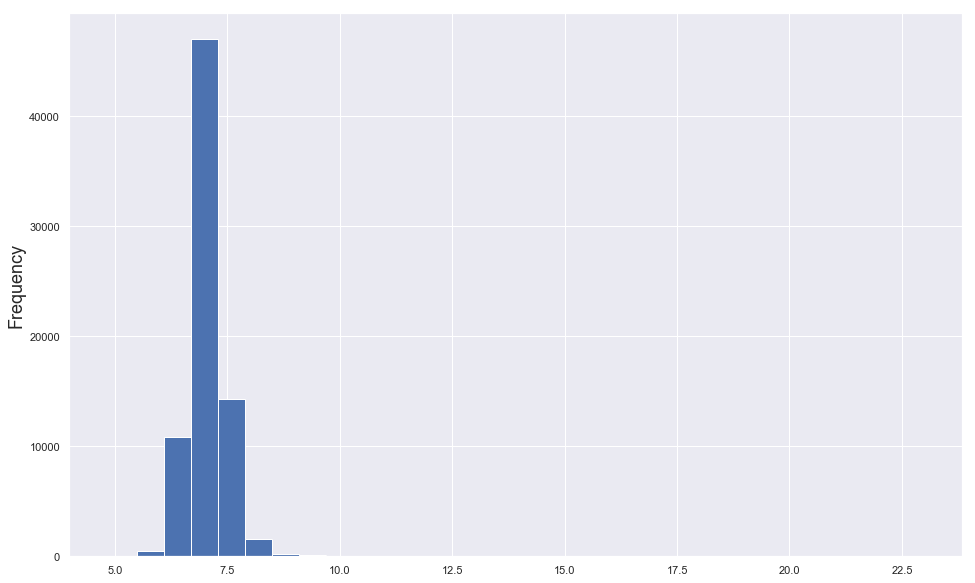

In [185]:
complexity_df['score'].plot.hist(bins=30)

The distribution follows normal distribution with a mean of roughly 7 with small variance.

### 3.1.2 Comparison of text complexity by year

In this subsection we are going to compare the complexity of the movie language for each year.
We want to see if the complexity differs across years.

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each year.

In [195]:
# get average score per year
by_year = complexity_df.groupby('year')['score'].mean().reset_index()

# sort the films by year
by_year = by_year.sort_values(by='year')

# convert year to int the 'year' value
by_year['year'] = pd.to_numeric(by_year['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
by_year = by_year.dropna()
by_year = by_year.reset_index(drop=True)
by_year['year'] = by_year['year'].astype('int')

In [196]:
years = list(by_year['year'])
labels = []
averages = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    average = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            average += int(by_year.loc[by_year['year'] == year]['score'])
            count += 1
    if count > 0:
        averages.append(average / count)

(0, 8)

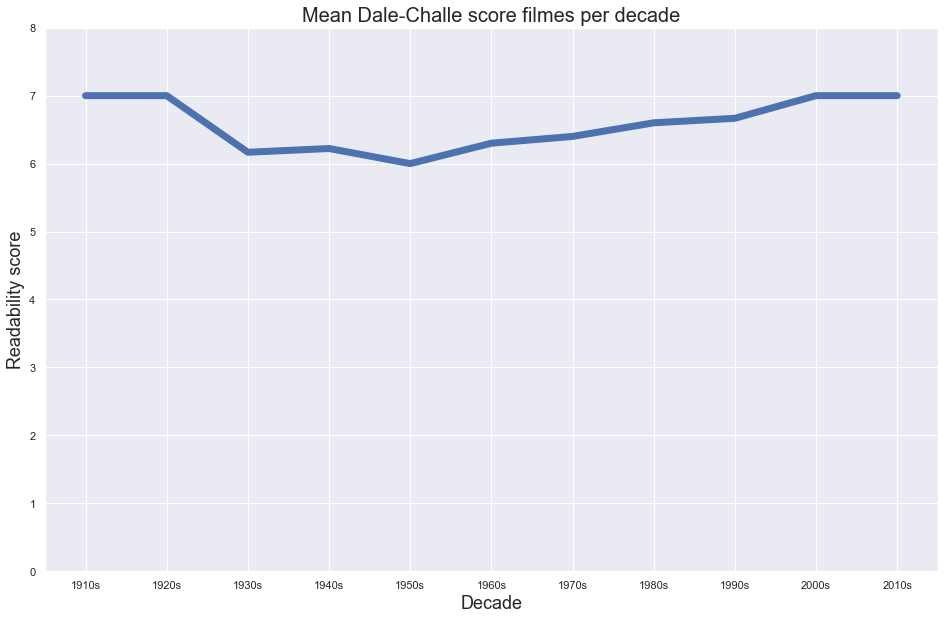

In [337]:
data = pd.DataFrame({'Decade': labels, 'Readability score':averages})
ax = sns.lineplot(x='Decade',
             y='Readability score', 
             linewidth=7.0,
             err_style='bars',
             data=data).set_title('Mean Dale-Challe score filmes per decade')
plt.ylim(0, 8)

#plt.figure(figsize=(15,10))
#plt.bar(labels, averages)
#plt.title('Average Dale–Chall readability per decade')
#plt.show()

The text complexity does not appear to differ much between decades. There is a small dip in the middle of the century.
The average Dale-Challe score for each century falls into the "easily understood by an average 7th or 8th-grade student" category. Put in other words, the text is not completly trivial but not very complicated.

### 3.1.3 Comparison of text complexity by genre

In this subsection we are going to compare the complexity of the movie language for each genre.
Do some genres use more simple language than others?

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each genre.

In [338]:
# make genre column into a list of genres
complexity_df_ = complexity_df_.withColumn("genre", F.split(complexity_df_.genre, ','))

# make a row for each genre
complexity_df_ = complexity_df_.withColumn("genre", F.explode("genre"))

complexity_df_ = complexity_df_.withColumn("genre", F.ltrim(complexity_df_.genre))
complexity_df_ = complexity_df_.withColumn("genre", F.rtrim(complexity_df_.genre))

In [339]:
# get count of each genre
genres_ = complexity_df_.groupby('genre').agg(F.avg('score').alias('avg_score'))

In [340]:
# convert to Pandas for plotting
genres = genres_.toPandas()

In [341]:
genres = genres.sort_values(by = 'avg_score')
genres = genres.rename({'avg_score': 'readability'})

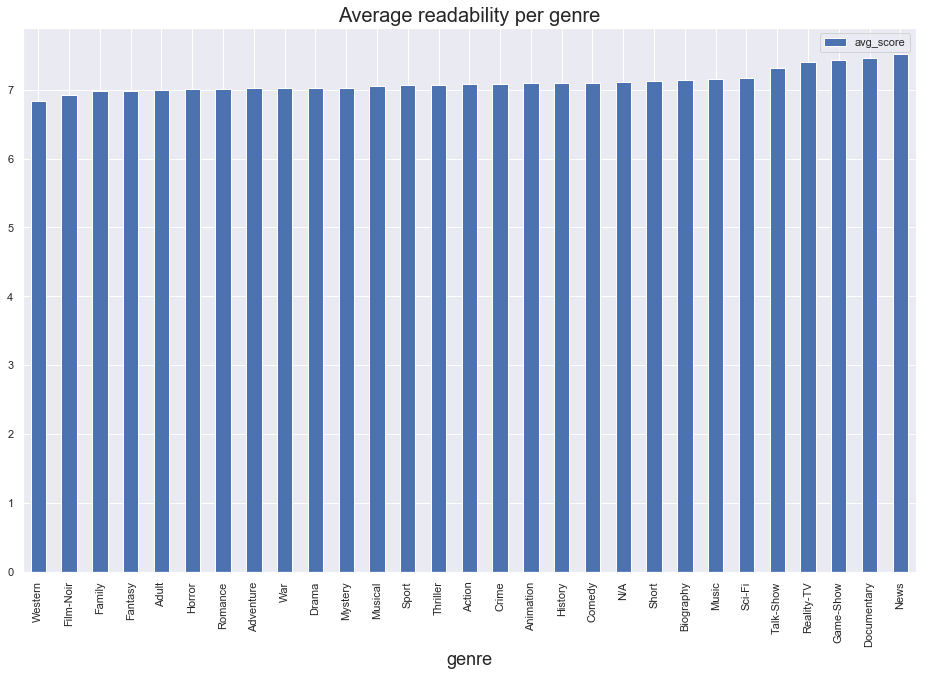

In [342]:
genres.plot.bar(x='genre', figsize=(16, 10), title="Average readability per genre")

It does not appear to be any significant different across genres with regard to readability.

## 3.2 Sentimental analysis

In this section we are going to perform sentimental analysis on the subtitle text. 

The aim of this section is to explore if movies express more or less positive emotion nowdays compared to back in the day. We also plan to explore how this property differ between genres. We plan to calculate the polarity of the text of each film with the help of textblob (https://textblob.readthedocs.io/en/dev/index.html). 

### 3.2.1 calculations

In [34]:
from textblob import TextBlob

In [35]:
subtitle_df = spark.read.parquet("./datasets/subtitles_final.parquet")#.sample(False, 0.0001)

# Remove null entries
subtitle_df = subtitle_df.filter((F.col("sentence").isNotNull()))

In [36]:
metadata_df = spark.read.parquet("datasets/metadata_final.parquet").select('_id', 'year')
subtitle_df = metadata_df.join(subtitle_df, '_id', 'inner')
subtitle_df = subtitle_df.filter('year > 1979')
subtitle_df = subtitle_df.filter('year < 1990')
# Maybe re run

In [37]:
@udf('float')
def calculate_polarity(sentence):
    untokenize = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in sentence]).strip()
    blob = TextBlob(untokenize)
    return blob.polarity
sentiment_df = subtitle_df.withColumn('polarity', calculate_polarity('sentence'))

In [ ]:
sentiment_df.write.mode("overwrite").parquet('./datasets/sentiment_1980_1989.parquet')

In [91]:
#sentiment_df.write.parquet('./datasets/sentiment_final.parquet')

### 3.2.2 Analysis

In [343]:
sentiment_df = spark.read.parquet('./datasets/sentiment_final_speed_v10.parquet')
sentiment_df.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- sentence: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- polarity: float (nullable = true)



The dataframe contains the polarity score of each sentence of every movie. Let's start with analysing the average polarity per movie. We can do this by grouping on the movie id aggregating by taking the mean of the polarity column.

In [344]:
sentiment_df_movie_mean = sentiment_df.groupby('_id').mean()
sentiment_df_movie_mean = sentiment_df_movie_mean.toPandas()
sentiment_df_movie_mean = sentiment_df_movie_mean.rename(columns={'avg(polarity)': 'polarity'})

In [345]:
sentiment_df_movie_mean.describe()

,_id,avg(_id),polarity
count,7.463600e+04,7.463600e+04,74636.000000
mean,1.154921e+08,1.154921e+08,0.035728
std,4.515793e+08,4.515793e+08,0.029206
min,2.900000e+01,2.900000e+01,-0.450000
25%,3.422480e+06,3.422480e+06,0.017858
50%,4.651539e+06,4.651539e+06,0.035170
75%,6.579919e+06,6.579919e+06,0.053162
max,1.955654e+09,1.955654e+09,0.850000


It appears that the average polarity score is pretty much zero for every single movie.

Let's have a look at the distribution as well:

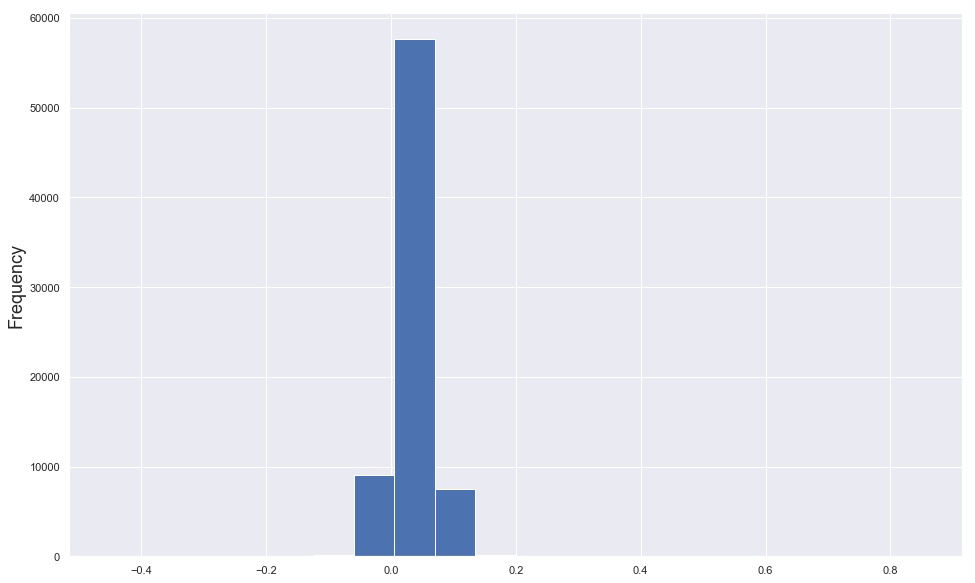

In [346]:
sentiment_df_movie_mean['polarity'].plot.hist(bins=20)

We do the same observation from the plot above as from the describe print out. Basically every movie has an average sentiment score of close to zero. This is not too surprising since most sentences in everyday conversation is quite neutral.

Instead of taking the average of polarity per movie, we will count the number of positive and negative sentences of each movie and use this to quantify how much negative and positive emotion a movie contains. 

In [347]:
sentiment_df_grouped = sentiment_df.withColumn('isPositive', (F.col('polarity') > 0).cast('int'))
sentiment_df_grouped = sentiment_df_grouped.withColumn('isNegative', (F.col('polarity') < 0).cast('int'))
sentiment_df_grouped = sentiment_df_grouped.withColumn('isNeutral', (F.col('polarity') == 0).cast('int'))
sentiment_df_grouped.show(5)

+-------+--------------------+----------+----------+----------+---------+
|    _id|            sentence|  polarity|isPositive|isNegative|isNeutral|
+-------+--------------------+----------+----------+----------+---------+
|6901081|[(, LOW, WHIRRING...|       0.0|         0|         0|        1|
|6901081|[(, INHALES, SHAR...|    -0.125|         0|         1|        0|
|6901081|[We, 've, nearly,...|0.11818182|         1|         0|        0|
|6901081|  [A, new, world, .]|0.13636364|         1|         0|        0|
|6901081|[For, the, next, ...|       0.3|         1|         0|        0|
+-------+--------------------+----------+----------+----------+---------+
only showing top 5 rows



In [348]:

exprs = [F.sum(x) for x in ['isPositive', 'isNegative', 'isNeutral']] + [F.mean(x) for x in ['polarity']]
sentiment_df_grouped = sentiment_df_grouped.groupby('_id').agg(*exprs)
sentiment_df_grouped = sentiment_df_grouped.select(
                                                   '_id',
                                                   F.col('sum(isPositive)').alias('isPositive'),
                                                   F.col('avg(polarity)').alias('polarity'),
                                                   F.col('sum(isNeutral)').alias('isNeutral'),
                                                   F.col('sum(isNegative)').alias('isNegative'))

In [349]:
sentiment_df_grouped.count()

74636

In [350]:
metadata_df = spark.read.parquet("datasets/metadata_final.parquet").select('_id','words','sentences', 'year', 'genre')

In [351]:
# get year and genre for each movie
sentiment_df_grouped = metadata_df.join(sentiment_df_grouped, '_id', 'inner')

In [352]:
sentiment_df_grouped.sort(F.desc("isPositive")).show(5)

+-------+------+---------+----+-------------------+----------+-------------------+---------+----------+
|    _id| words|sentences|year|              genre|isPositive|           polarity|isNeutral|isNegative|
+-------+------+---------+----+-------------------+----------+-------------------+---------+----------+
|5131043|314125|    21669|1965|Documentary,History|       770|0.06872464044632634|     1113|       338|
|5131042|211040|    15268|1965|Documentary,History|       529| 0.0667828792189208|      742|       246|
|3109052|234147|    29085|1989|          Drama,War|       428|0.03440006832817369|     2238|       225|
|4986273|151418|    19453|2010|     Comedy,Romance|       399|0.03907067797052602|     1342|       208|
|6274066|135037|    17875|null|               null|       370|0.03787229882459167|     1250|       202|
+-------+------+---------+----+-------------------+----------+-------------------+---------+----------+
only showing top 5 rows



### 3.2.3 Comparison of text sentiment by year

In [353]:
sentiment_df_grouped = sentiment_df_grouped.filter(F.col("year").isNotNull())

In [354]:
sentiment_df_pandas = sentiment_df_grouped.toPandas()

In [355]:
sentiment_df_pandas['decade'] = (by_year['year'] - (by_year['year'] % 10)).astype(int)
sentiment_df_pandas = sentiment_df_pandas[sentiment_df_pandas['decade'] != 1900]
sentiment_df_pandas = sentiment_df_pandas[sentiment_df_pandas['decade'] != 1890]
sentiment_df_pandas.head()

,_id,words,sentences,year,genre,isPositive,polarity,isNeutral,isNegative,decade
2,3395462,13244,1876,2008,"Comedy,Romance",45,0.062552,148,20,1910.0
3,5700717,12513,1768,2000,"Action,Crime,Drama",36,0.051039,145,14,1910.0
4,3547417,11445,1324,1989,"Crime,Drama,Mystery",33,0.061601,70,9,1910.0
5,3402859,10853,1414,1993,"Crime,Drama,Thriller",12,0.015744,86,11,1910.0
6,3340251,10498,1488,2008,"Adventure,Comedy,Family",40,0.089373,111,12,1920.0


In [356]:
by_decade = sentiment_df_pandas.groupby('decade')['polarity'].mean()

In [357]:
by_decade.index = by_decade.index.astype(str) + "s"

In [358]:
by_decade.head()

1910.0s    0.047734
1920.0s    0.071009
1930.0s    0.044521
1940.0s    0.054865
1950.0s    0.025640
Name: polarity, dtype: float64

"\nplt.figure(figsize=(15,10))\nax = plt.bar(by_decade.index, by_decade)\nplt.title('Mean sentiment')\nplt.xlabel('Decade')\nplt.ylabel('sentiment score.')\nplt.show()\n"

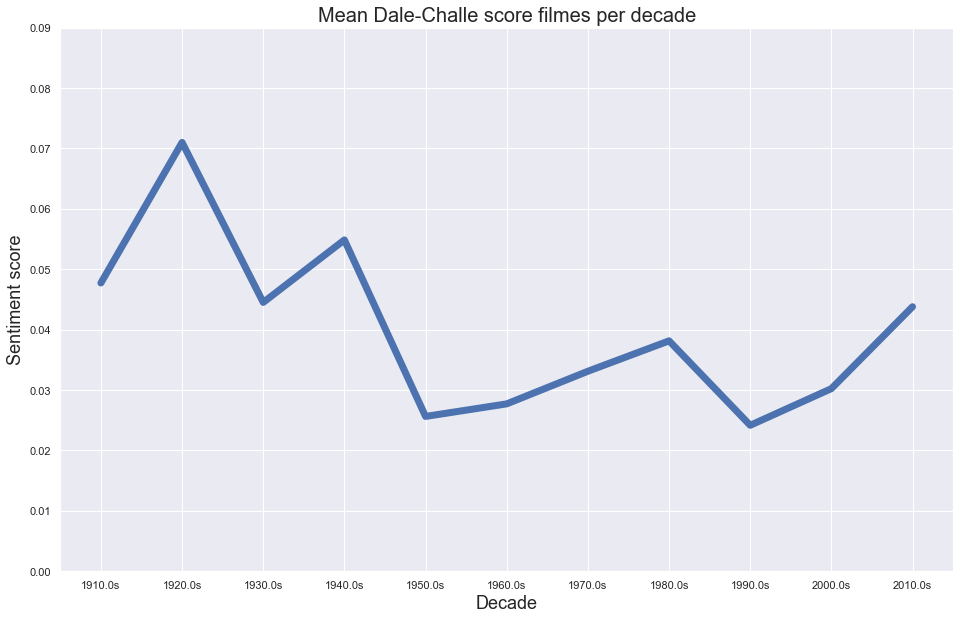

In [363]:
data = pd.DataFrame({'Decade': by_decade.index, 'Sentiment score':by_decade})
ax = sns.lineplot(x='Decade',
             y='Sentiment score', 
             linewidth=7.0,
             err_style='bars',
             data=data).set_title('Mean Dale-Challe score filmes per decade')
plt.ylim(0, 0.09)


"""
plt.figure(figsize=(15,10))
ax = plt.bar(by_decade.index, by_decade)
plt.title('Mean sentiment')
plt.xlabel('Decade')
plt.ylabel('sentiment score.')
plt.show()
"""

### 3.2.3 Comparison of text sentiment by genre

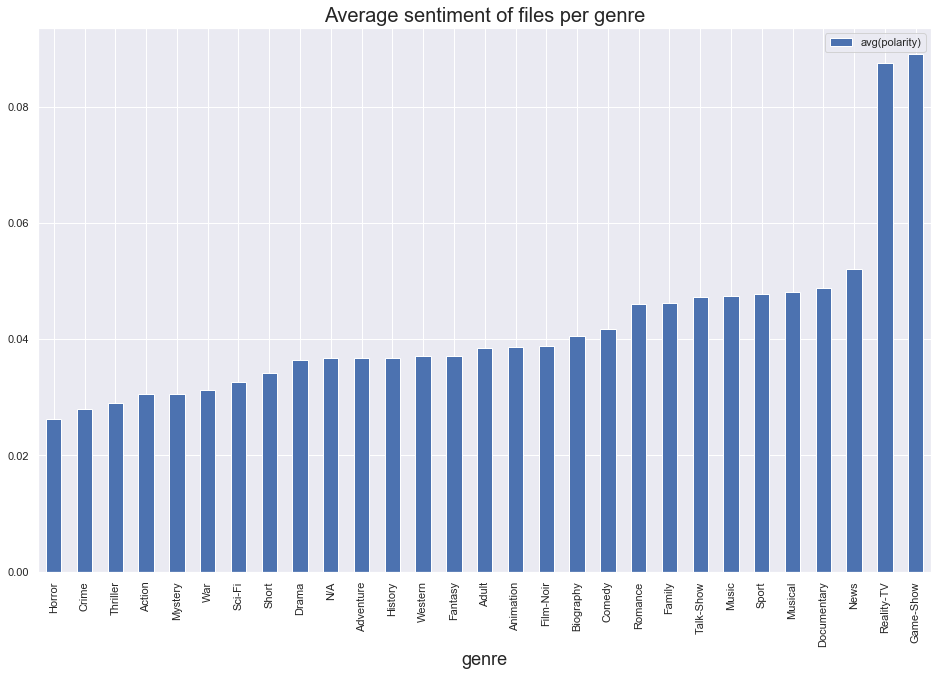

In [365]:
# make genre column into a list of genres
sentiment_df = spark.read.parquet('./datasets/sentiment_final_speed_v10.parquet')

metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
# get year and genre for each movie
sentiment_df_genre = metadata_df.join(sentiment_df, '_id', 'inner')

sentiment_df_genre = sentiment_df_genre.withColumn("genre", F.split(sentiment_df_genre.genre, ','))

# make a row for each genre
sentiment_df_genre = sentiment_df_genre.withColumn("genre", F.explode("genre"))

sentiment_df_genre = sentiment_df_genre.withColumn("genre", F.ltrim(sentiment_df_genre.genre))
sentiment_df_genre = sentiment_df_genre.withColumn("genre", F.rtrim(sentiment_df_genre.genre))


sentiment_df_genre = sentiment_df_genre.groupby('genre').mean()

# convert to Pandas for plotting
genres = sentiment_df_genre.toPandas()

genres = genres.sort_values(by = 'avg(polarity)')[['genre','avg(polarity)']]
genres.plot.bar(x='genre', figsize=(16, 10), title="Average sentiment of filmes per genre")

## 3.3 Offensive language analysis

In this section we are going to analyize the use of offensive/swear words in subtitle text. 

We will use resources such as offensive word lexicons (https://github.com/zacanger/profane-words/blob/master/words.json) to quantify the level of offensivity of a certain film. Then, we are going to check the level of offensivity in relation to years (are films more/less offensive now) and genres (do some genres use more offensive words)

### 3.3.1

In [366]:
subtitle_df = spark.read.parquet("./datasets/subtitles_final.parquet")
# Remove null entries
subtitle_df = subtitle_df.filter((F.col("sentence").isNotNull()))

In [ ]:
profanity_list = spark.read.json('words_out.json').collect()
profanity_list = list(map(lambda x: x.word.strip(), profanity_list))

All the words in the list of bad words are lowercased, we will therefore convert all of our sentences to lower case as well.

In [ ]:
# Convert all words to lowercase
subtitle_df = subtitle_df.select('_id', toLower('sentence._VALUE').alias('sentence'))/Users/jakobsvenningsson/nltk_datast

Let's define a simple helper function which will be used to count the profanities in a sentence.

In [135]:
@udf('int')
def number_of_profanities(sentence):
    return len(list(filter(lambda word: word in profanity_list, sentence)))

In [136]:
profanity_df = subtitle_df.withColumn('number_of_profanities', number_of_profanities(F.col('sentence')))

In [ ]:
profanity_df.write.mode('overwrite').parquet('./datasets/profanity_final.parquet')

### 3.3.2 calculations

For the analysis we will need calculate the proportion of profanities per movies. We hence need the total amount of words in each moveis which can be found in the meta data dataframe. Let's start by joining the profanity dataframe and the metadata data frame.

In [368]:
profanity = spark.read.parquet('./datasets/profanity_final.parquet')
profanity.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- number_of_profanities: long (nullable = true)



In [369]:
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
# get year and genre for each movie
profanity_df = metadata_df.join(profanity, '_id', 'inner')

In [370]:
profanity_df = profanity_df.toPandas()

In [371]:
profanity_df.describe()

,_id,year,sentences,words,duration,numVotes,averageRating,number_of_profanities
count,7.467400e+04,74416.000000,74674.000000,74674.000000,74674.000000,7.398700e+04,73987.000000,74674.000000
mean,1.155133e+08,1995.366118,1396.378525,10016.804390,103.988416,6.373126e+04,6.673066,86.912339
std,4.516214e+08,21.925659,646.187617,5023.267461,64.701701,1.534993e+05,1.138114,83.035338
min,2.900000e+01,1896.000000,3.000000,34.000000,61.000000,5.000000e+00,1.400000,0.000000
25%,3.421585e+06,1988.000000,983.000000,6856.000000,87.000000,1.215000e+03,6.100000,39.000000
50%,4.651536e+06,2006.000000,1325.000000,9408.500000,97.000000,7.506000e+03,6.800000,63.000000
75%,6.580001e+06,2011.000000,1724.000000,12520.750000,113.000000,5.308500e+04,7.500000,107.000000
max,1.955654e+09,2017.000000,29085.000000,314125.000000,5999.000000,1.985076e+06,9.900000,2191.000000


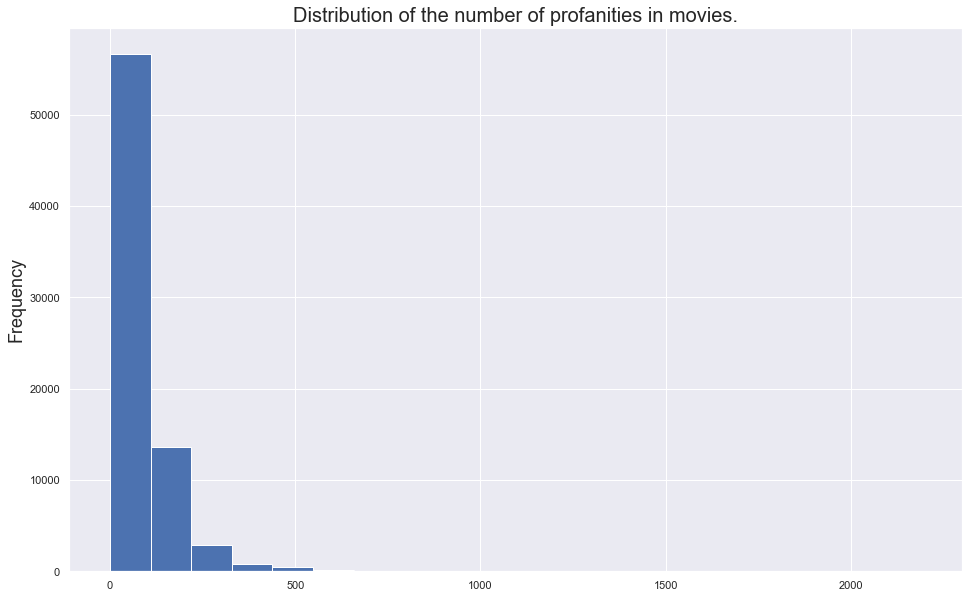

In [372]:
profanity_df['number_of_profanities'].plot.hist(bins=20, 
                                                title="Distribution of the number of profanities in movies.")

In [373]:
profanity_df['porportion_of_profanities'] = profanity_df['number_of_profanities'] / profanity_df['words']

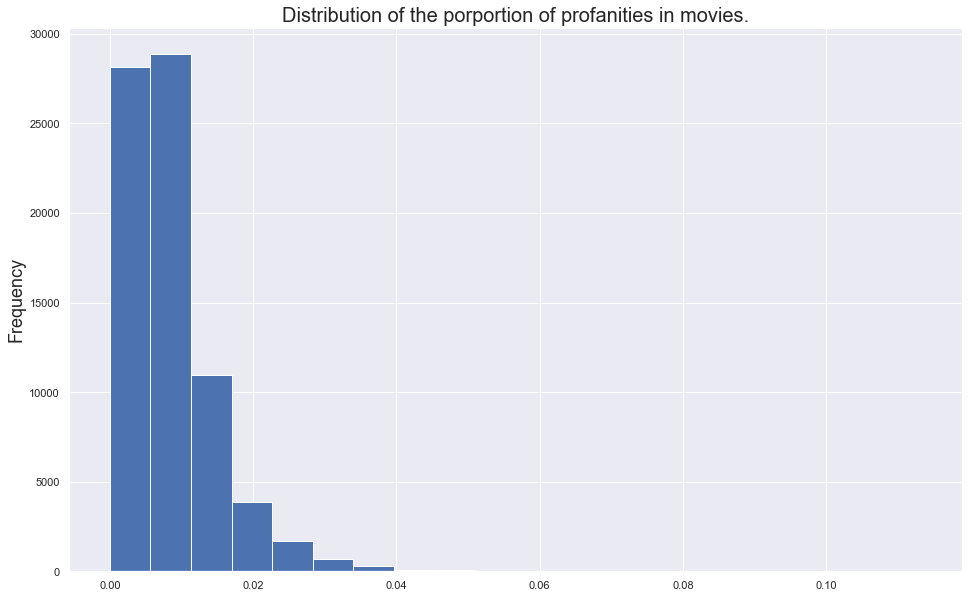

In [374]:
profanity_df['porportion_of_profanities'].plot.hist(bins=20, 
                                                    title="Distribution of the porportion of profanities in movies.")

### 3.3.3 Comparison of profane language by year

In [375]:
profanity_df = profanity_df.dropna(subset=['year'])

In [376]:
profanity_df['decade'] = (profanity_df['year'] - (profanity_df['year'] % 10)).astype(int)
profanity_df.head()

,_id,genre,year,sentences,words,duration,numVotes,averageRating,imdb_id,number_of_profanities,porportion_of_profanities,decade
0,1955331714,"Action,Adventure,Drama",1991.0,1323,8916,102,5913.0,6.2,102178,102,0.011440,1990
1,3299564,"Drama,Music,Romance",2008.0,1465,10491,90,74721.0,6.3,1023481,44,0.004194,2000
2,3482833,"Drama,Music,Romance",2008.0,1464,10489,88,74721.0,6.3,1023481,44,0.004195,2000
3,3299723,"Drama,Music,Romance",2008.0,1593,11464,97,74721.0,6.3,1023481,48,0.004187,2000
4,3288587,"Drama,Music,Romance",2008.0,1837,11994,103,74721.0,6.3,1023481,54,0.004502,2000


In [377]:
profanity_df.dtypes

_id                            int32
genre                         object
year                         float64
sentences                      int32
words                          int32
duration                       int32
numVotes                     float64
averageRating                float32
imdb_id                       object
number_of_profanities          int64
porportion_of_profanities    float64
decade                         int64
dtype: object

In [378]:
profanity_df = profanity_df[profanity_df['decade'] != 1900]
profanity_df = profanity_df[profanity_df['decade'] != 1890]

In [379]:
profanity_df_by_year = profanity_df\
    .groupby('decade')\
    .mean()[['number_of_profanities', 'porportion_of_profanities']]
profanity_df_by_year.index = profanity_df_by_year.index.astype(str) + "s"

In [380]:
profanity_df_by_year.head(20)

,number_of_profanities,porportion_of_profanities
1910s,38.333333,0.007029
1920s,13.579661,0.004961
1930s,48.411362,0.004234
1940s,53.369015,0.004331
1950s,48.383495,0.004506
1960s,56.684352,0.006190
1970s,68.205284,0.007504
1980s,85.360432,0.008973
1990s,106.730147,0.010056
2000s,95.857056,0.009682


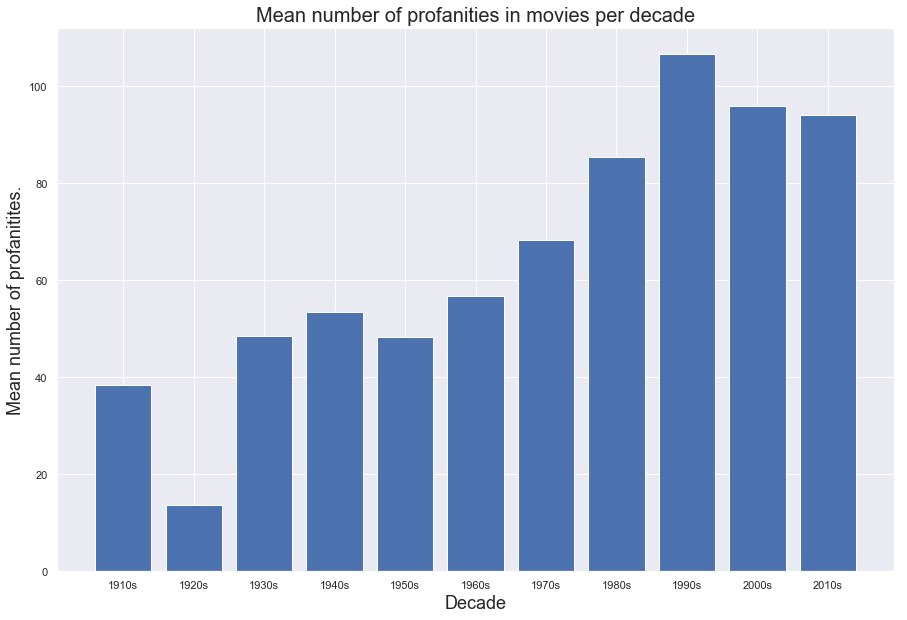

In [381]:
plt.figure(figsize=(15,10))
ax = plt.bar(profanity_df_by_year.index, profanity_df_by_year['number_of_profanities'])
plt.title('Mean number of profanities in movies per decade')
plt.xlabel('Decade')
plt.ylabel('Mean number of profanitites.')
plt.show()

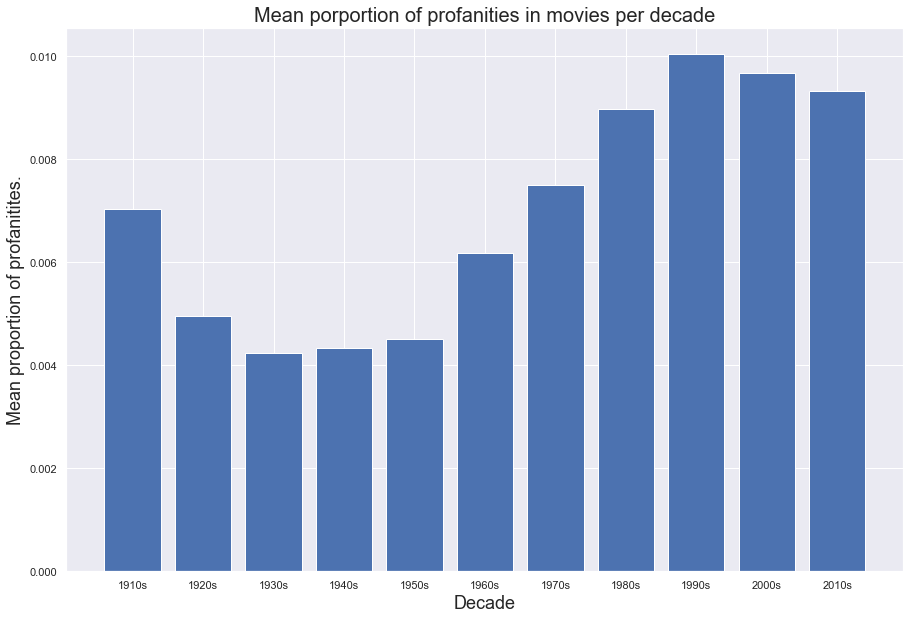

In [382]:
plt.figure(figsize=(15,10))
ax = plt.bar(profanity_df_by_year.index, profanity_df_by_year['porportion_of_profanities'])
plt.title('Mean porportion of profanities in movies per decade')
plt.xlabel('Decade')
plt.ylabel('Mean proportion of profanitites.')
plt.show()

The above diagram tells us that the number of profanities in movies have increased over time. There are many more profanities used today compared 50 years ago. An interesting outlier is the decade of 1910 which has a higher porpotion than its neighbors. What can be the explanation for this? Could there be that there were words back then which were not considered "bad" and uses heavily in everyday langauge? Another possible explanation is that we do not have a lot of data points from 1910 and 1920 which could be a explanation for the varaiance.

### 3.3.3 Comparison of profane language by genre

Index(['genre', 'avg(_id)', 'avg(year)', 'avg(sentences)', 'avg(words)',
       'avg(duration)', 'avg(numVotes)', 'avg(averageRating)',
       'avg(number_of_profanities)', 'avg(porportion_of_profanities)'],
      dtype='object')


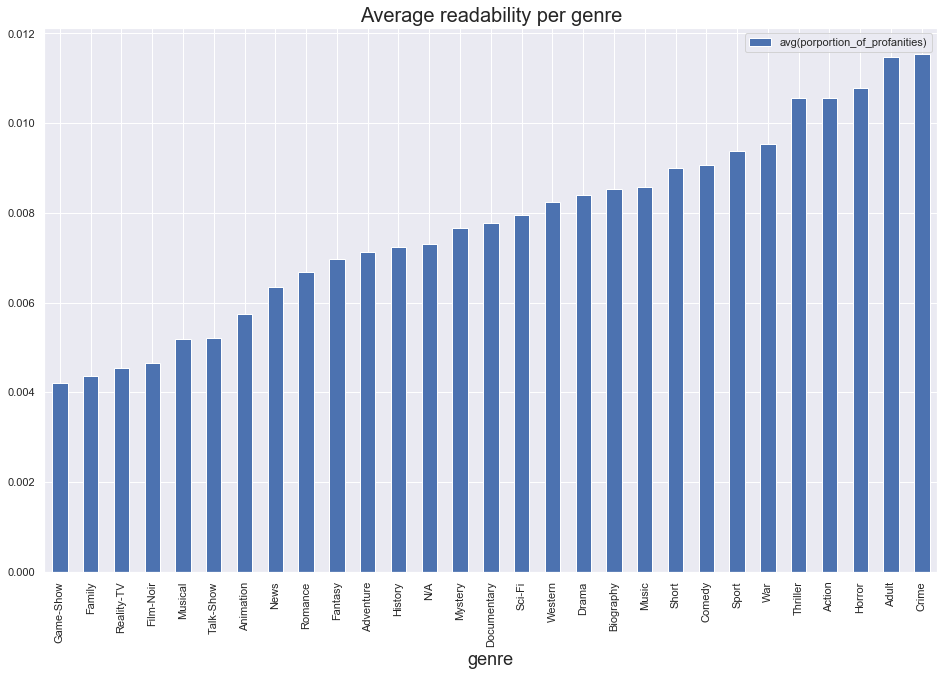

In [383]:
# make genre column into a list of genres
profanity = spark.read.parquet('./datasets/profanity_final.parquet')

metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
# get year and genre for each movie
profanity_df_genre = metadata_df.join(profanity, '_id', 'inner')

profanity_df_genre = profanity_df_genre.withColumn("genre", F.split(profanity_df_genre.genre, ','))

# make a row for each genre
profanity_df_genre = profanity_df_genre.withColumn("genre", F.explode("genre"))

profanity_df_genre = profanity_df_genre.withColumn("genre", F.ltrim(profanity_df_genre.genre))
profanity_df_genre = profanity_df_genre.withColumn("genre", F.rtrim(profanity_df_genre.genre))


profanity_df_genre = profanity_df_genre.withColumn('porportion_of_profanities', F.col('number_of_profanities') / F.col('words'))


profanity_df_genre = profanity_df_genre.groupby('genre').mean()

# convert to Pandas for plotting
genres = profanity_df_genre.toPandas()

print(genres.columns)

genres = genres.sort_values(by = 'avg(porportion_of_profanities)')[['genre','avg(porportion_of_profanities)']]
genres.plot.bar(x='genre', figsize=(16, 10), title="Average readability per genre")

## 3.4 Correlation between text properties and IMDB rating

In this section we are going to search for correlation between the film textual properties obtained in sections 3.1, 3.2 and 3.3 and its IMDB rating.

We will explore correlation by trying to fit a regression line to the data. We will use seaborn's regplot for the task.

## 3.4.1 Readability

Let's start by importing the complexity dataframe and the metadata dataframe. We need to join both dataframes to obtain a dataframe which contains both the complexity score and the imdb rating for each movie.

In [745]:
readability = spark.read.parquet('./datasets/complexity_final.parquet')
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
readability_imdb_df = metadata_df.join(readability, '_id', 'inner')

Let's make sure there are unwanted null values before we proceed.

In [515]:
readability_imdb_df = readability_imdb_df.filter(F.col("score").isNotNull())
readability_imdb_df = readability_imdb_df.filter(F.col("averageRating").isNotNull())

In order to do a regplot with seaborn we need to convert our spark dataframe to a pandas dataframe

In [746]:
readability_imdb_df = readability_imdb_df.select('averageRating', F.col('score').cast('float')).toPandas()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


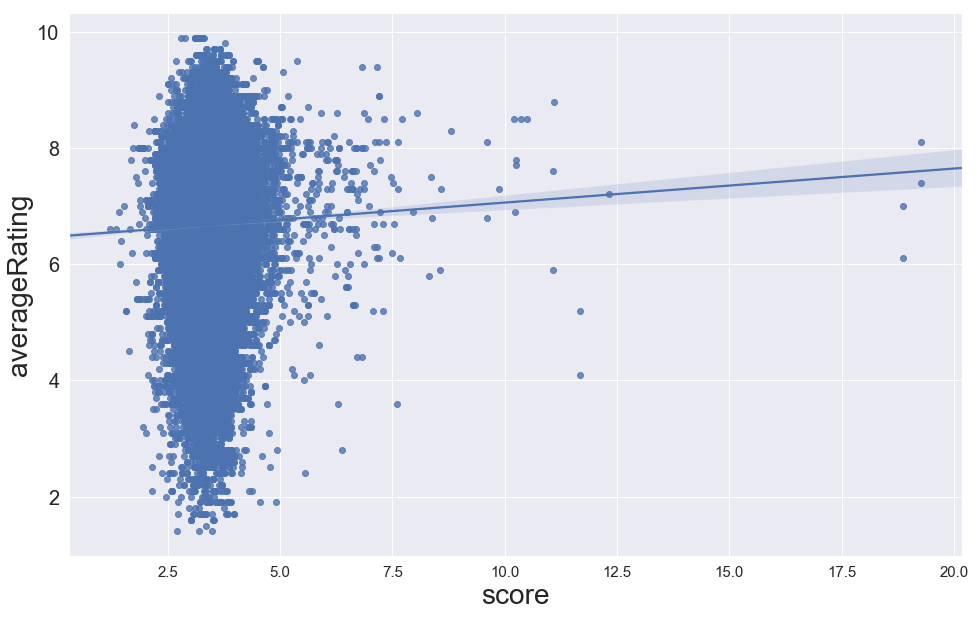

In [747]:
ax = sns.regplot(x="score", y="averageRating", data=readability_imdb_df)

As can be observed in the plot above, there is no correlation between imdb rating and the text complexity.

## 3.4.2 Polarity

Let's start by importing the neccasary data.

In [750]:
polarity = spark.read.parquet('./datasets/sentiment_final_speed_v10.parquet')
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
polarity_imdb_df = polarity.groupby('_id').mean().select('_id', F.col('avg(polarity)').alias('polarity'))
polarity_imdb_df = metadata_df.join(polarity_imdb_df, '_id', 'inner')

Clean potential null values:

In [751]:
polarity_imdb_df = polarity_imdb_df.filter(F.col("polarity").isNotNull())
polarity_imdb_df = polarity_imdb_df.filter(F.col("averageRating").isNotNull())

In [752]:
polarity_imdb_df = polarity_imdb_df.toPandas()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


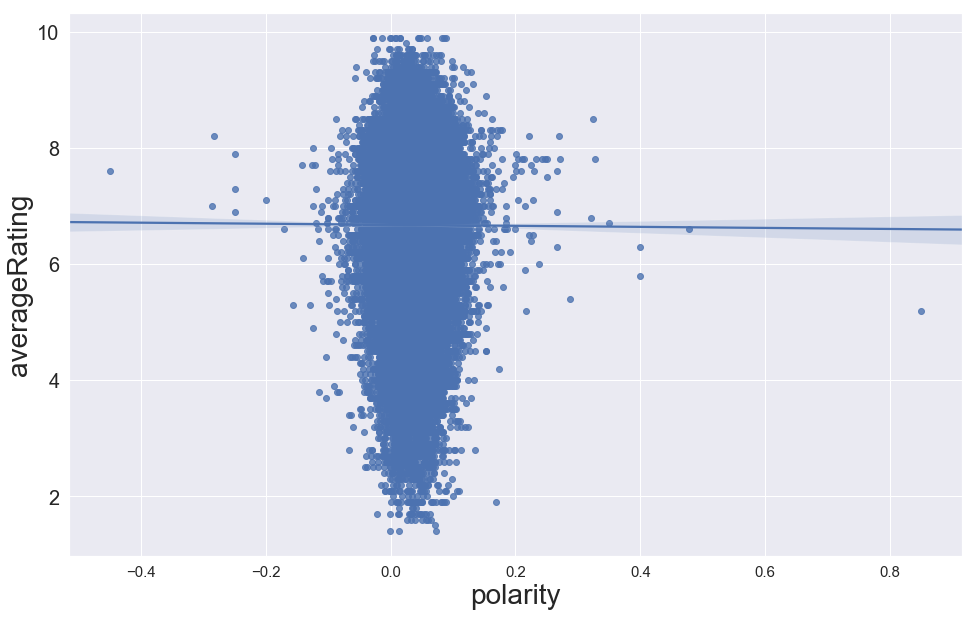

In [754]:
ax = sns.regplot(x="polarity", y="averageRating", data=polarity_imdb_df)

It appears like the polarity score of a movie is completly unrelated to it's imdb rating. 

## 3.4.3 Profanity

Let's load the data we need for correlation analysis.

In [617]:
profanity = spark.read.parquet('./datasets/profanity_final.parquet')
metadata_df = spark.read.parquet("datasets/metadata_final.parquet")
profanity_imdb_df = metadata_df.join(profanity, '_id', 'inner')

In [618]:
profanity_imdb_df = profanity_imdb_df.filter(F.col("number_of_profanities").isNotNull())
profanity_imdb_df = profanity_imdb_df.filter(F.col("averageRating").isNotNull())

In [619]:
profanity_imdb_df = profanity_imdb_df.toPandas()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


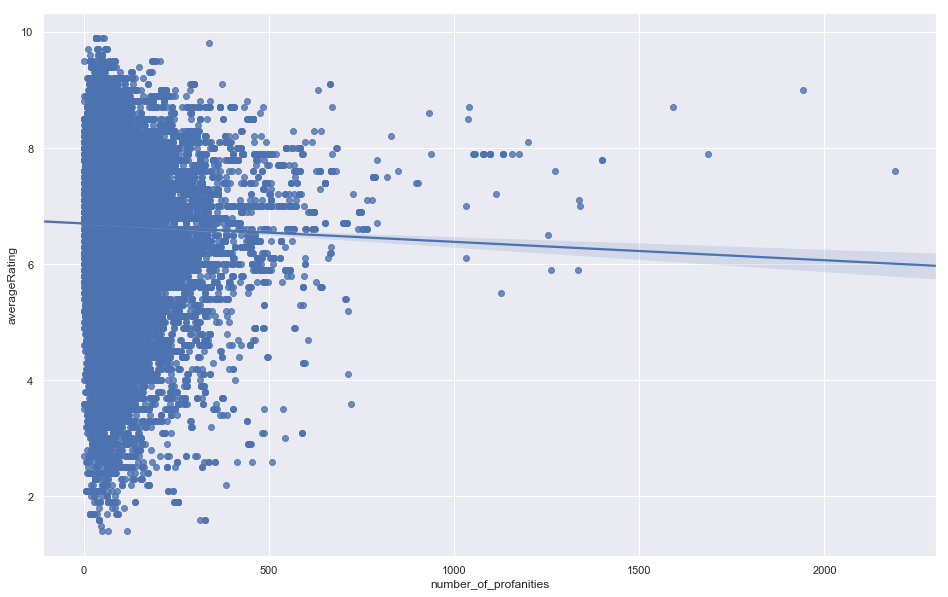

In [620]:
ax = sns.regplot(x="number_of_profanities", y="averageRating", data=profanity_imdb_df)

The number of profanities has a bit more variance compared to the sentiment and the text complexity but again we can see no correlation with imdb rating.

# PLOTS REMOVE BEFORE FINAL SUBMISSION

Text(0.5,1,'Median film duration per decade')

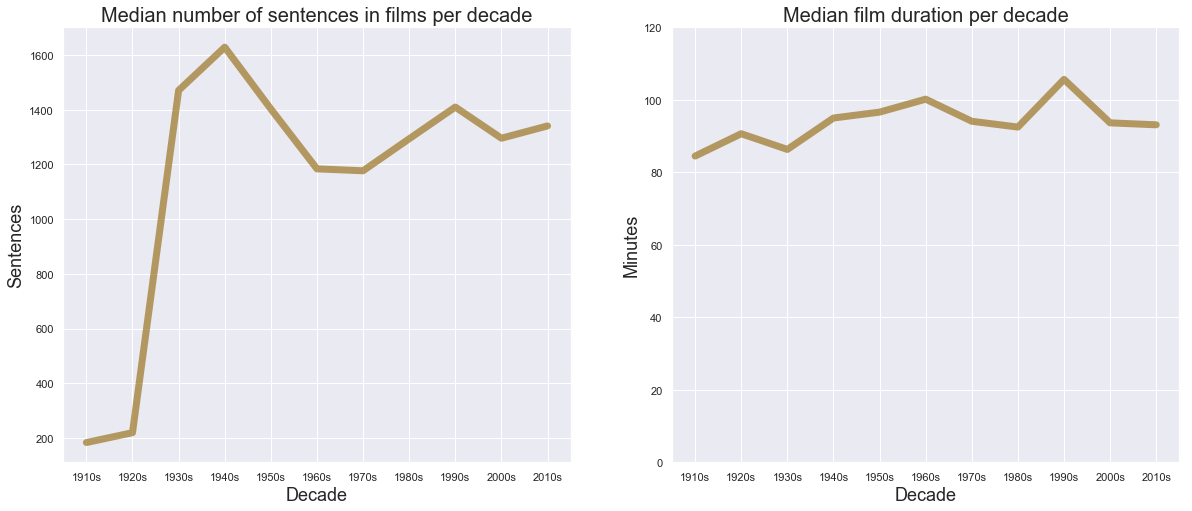

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(x='Decade',
             y='Sentences', 
             linewidth=7.0,
             ax=ax[0],
             color='#946a0fa4',
             data=data).set_title('Median number of sentences in films per decade')
plt.ylim(0, 120)
sns.lineplot(x='Decade',
             y='Minutes', 
             linewidth=7.0,
             ax=ax[1],
             color='#946a0fa4',
             data=film_duration_data).set_title('Median film duration per decade')

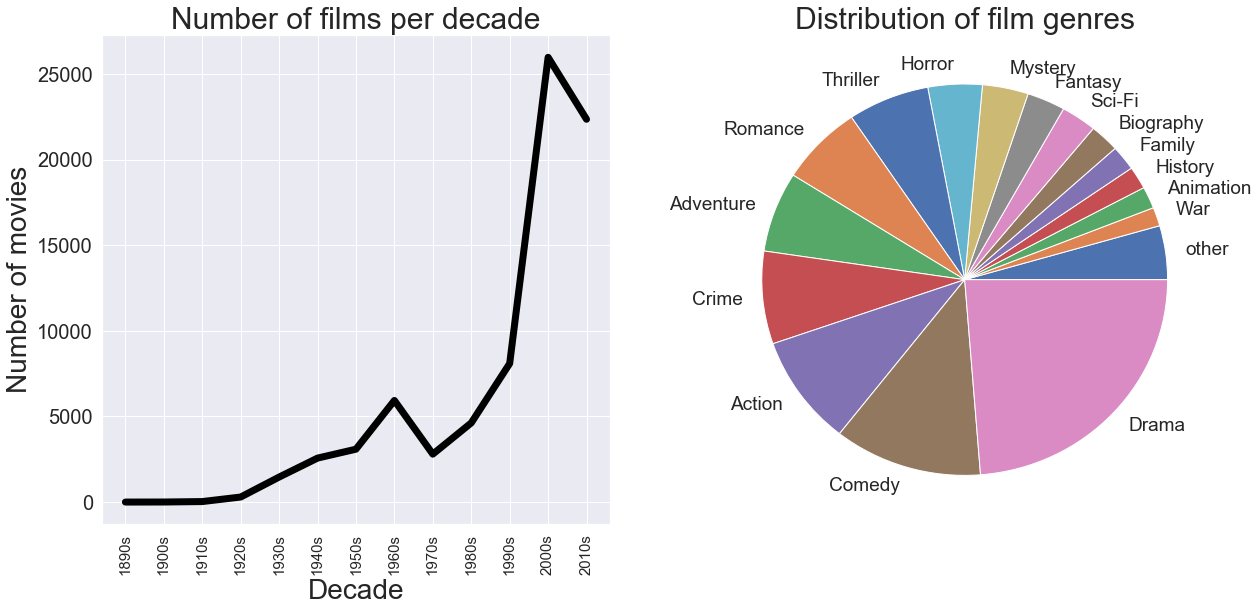

In [744]:
sns.set_context({"font.size":25,"axes.titlesize":30,"axes.labelsize":28})
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=20
plot, ax = plt.subplots(1, 2, figsize=(20, 9))
#plt.figure(figsize=(10,10))plt.xticks(fontsize=40, rotation=90)
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})
sns.set_style("darkgrid")


tmp = genres.copy()
otherCount = tmp.head()['count'].sum()
tmp = tmp.iloc[5:]
other = [{'genre': 'other', 'count': otherCount}]
tmp = pd.concat([pd.DataFrame(other), tmp], ignore_index=True,sort=False)
ax[1] = plt.pie(tmp['count'], labels=tmp['genre'], textprops={'fontsize': 19})
plt.title('Distribution of film genres')
g = sns.lineplot(x='Decade',
             y='Number of movies', 
             linewidth=7.0,
             ax=ax[0],
             color='black',
             data=data_movie_dist)
g.set_title('Number of films per decade')
g.set_xticklabels(data_movie_dist['Decade'], rotation='vertical')
plt.savefig('./plots/genres_movies.png', transparent=True, box_inches = 'tight')

In [458]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
a = sns.lineplot(x='Decade',
             y='Rating', 
             linewidth=7.0,
             ax=ax[0],
             color='#946a0fa4',
             data=data).set_title('Mean imdb rating of filmes per decade')
ax[0].set_ylim(0, 9)
ax[1] = movies_with_ratings_pandas['averageRating']\
    .plot\
    .hist(title="Ditibution of IMDB ratings", grid=True, bins=20, color='#946a0fa4')
ax[1].set_xlabel("IMDB rating")


SyntaxError: unexpected EOF while parsing (<ipython-input-458-c7232e71a858>, line 11)

(3, 8)

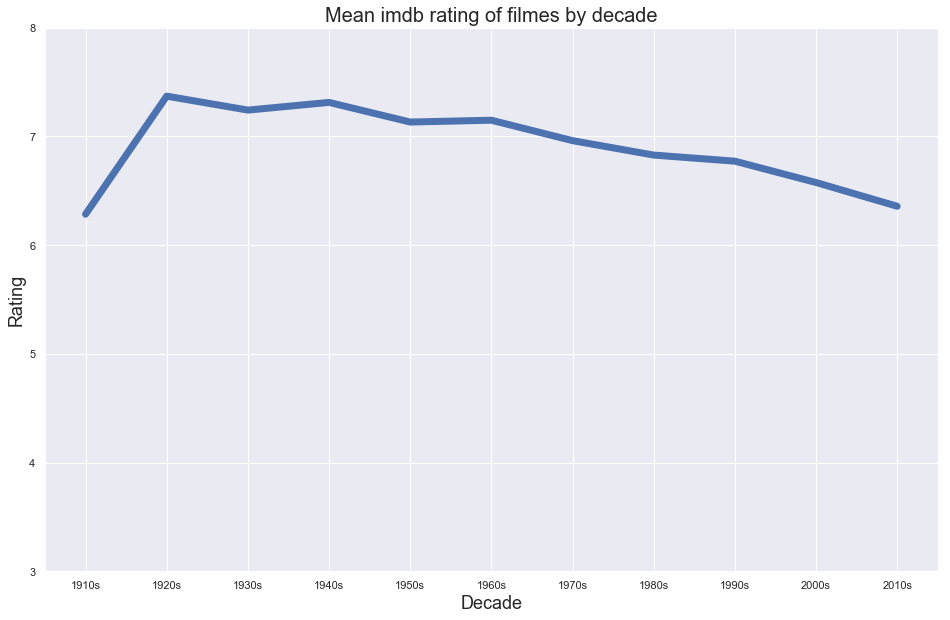

In [411]:
data = pd.DataFrame({'Decade': decade_imdb_mean.index, 'Rating':decade_imdb_mean})

plt.ylim(3, 8)